<a href="https://colab.research.google.com/github/EvgenEgorov/transcriptomics_msu_HW/blob/main/HW14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 14. Определение типов клеток



In [ ]:
!pip install scanpy[leiden] anndata2ri scikit-misc scvi-tools harmonypy

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

## Работа с Azimuth

Подготовка .h5ad-файла с каунтами (нужен для того, чтобы загрузить в Azimuth):

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Настраиваем эститику иллюстраций
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sns.set_style("ticks")

adata = sc.datasets.pbmc3k()

In [ ]:
# Проверяем, что у нас хранятся точно каунты
adata.X.sum(axis=1)

matrix([[2421.],
        [4903.],
        [3149.],
        ...,
        [1684.],
        [1024.],
        [1985.]], dtype=float32)

In [ ]:
adata.write_h5ad("Azimuth.h5ad")

Теперь можем загрузить к себе на компьютер файл `Azimuth.h5ad` и загрузить его на платформу <a href="https://azimuth.hubmapconsortium.org/">Azimuth</a> (в качестве референса необходимо выбрать PBMC).
```
Работа с веб-сервисом.
```
Теперь визуализируем результаты на наших данных:

In [ ]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

sc.pp.scale(adata)
sc.tl.pca(adata)

sc.pp.neighbors(
    adata,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

sc.tl.umap(adata)

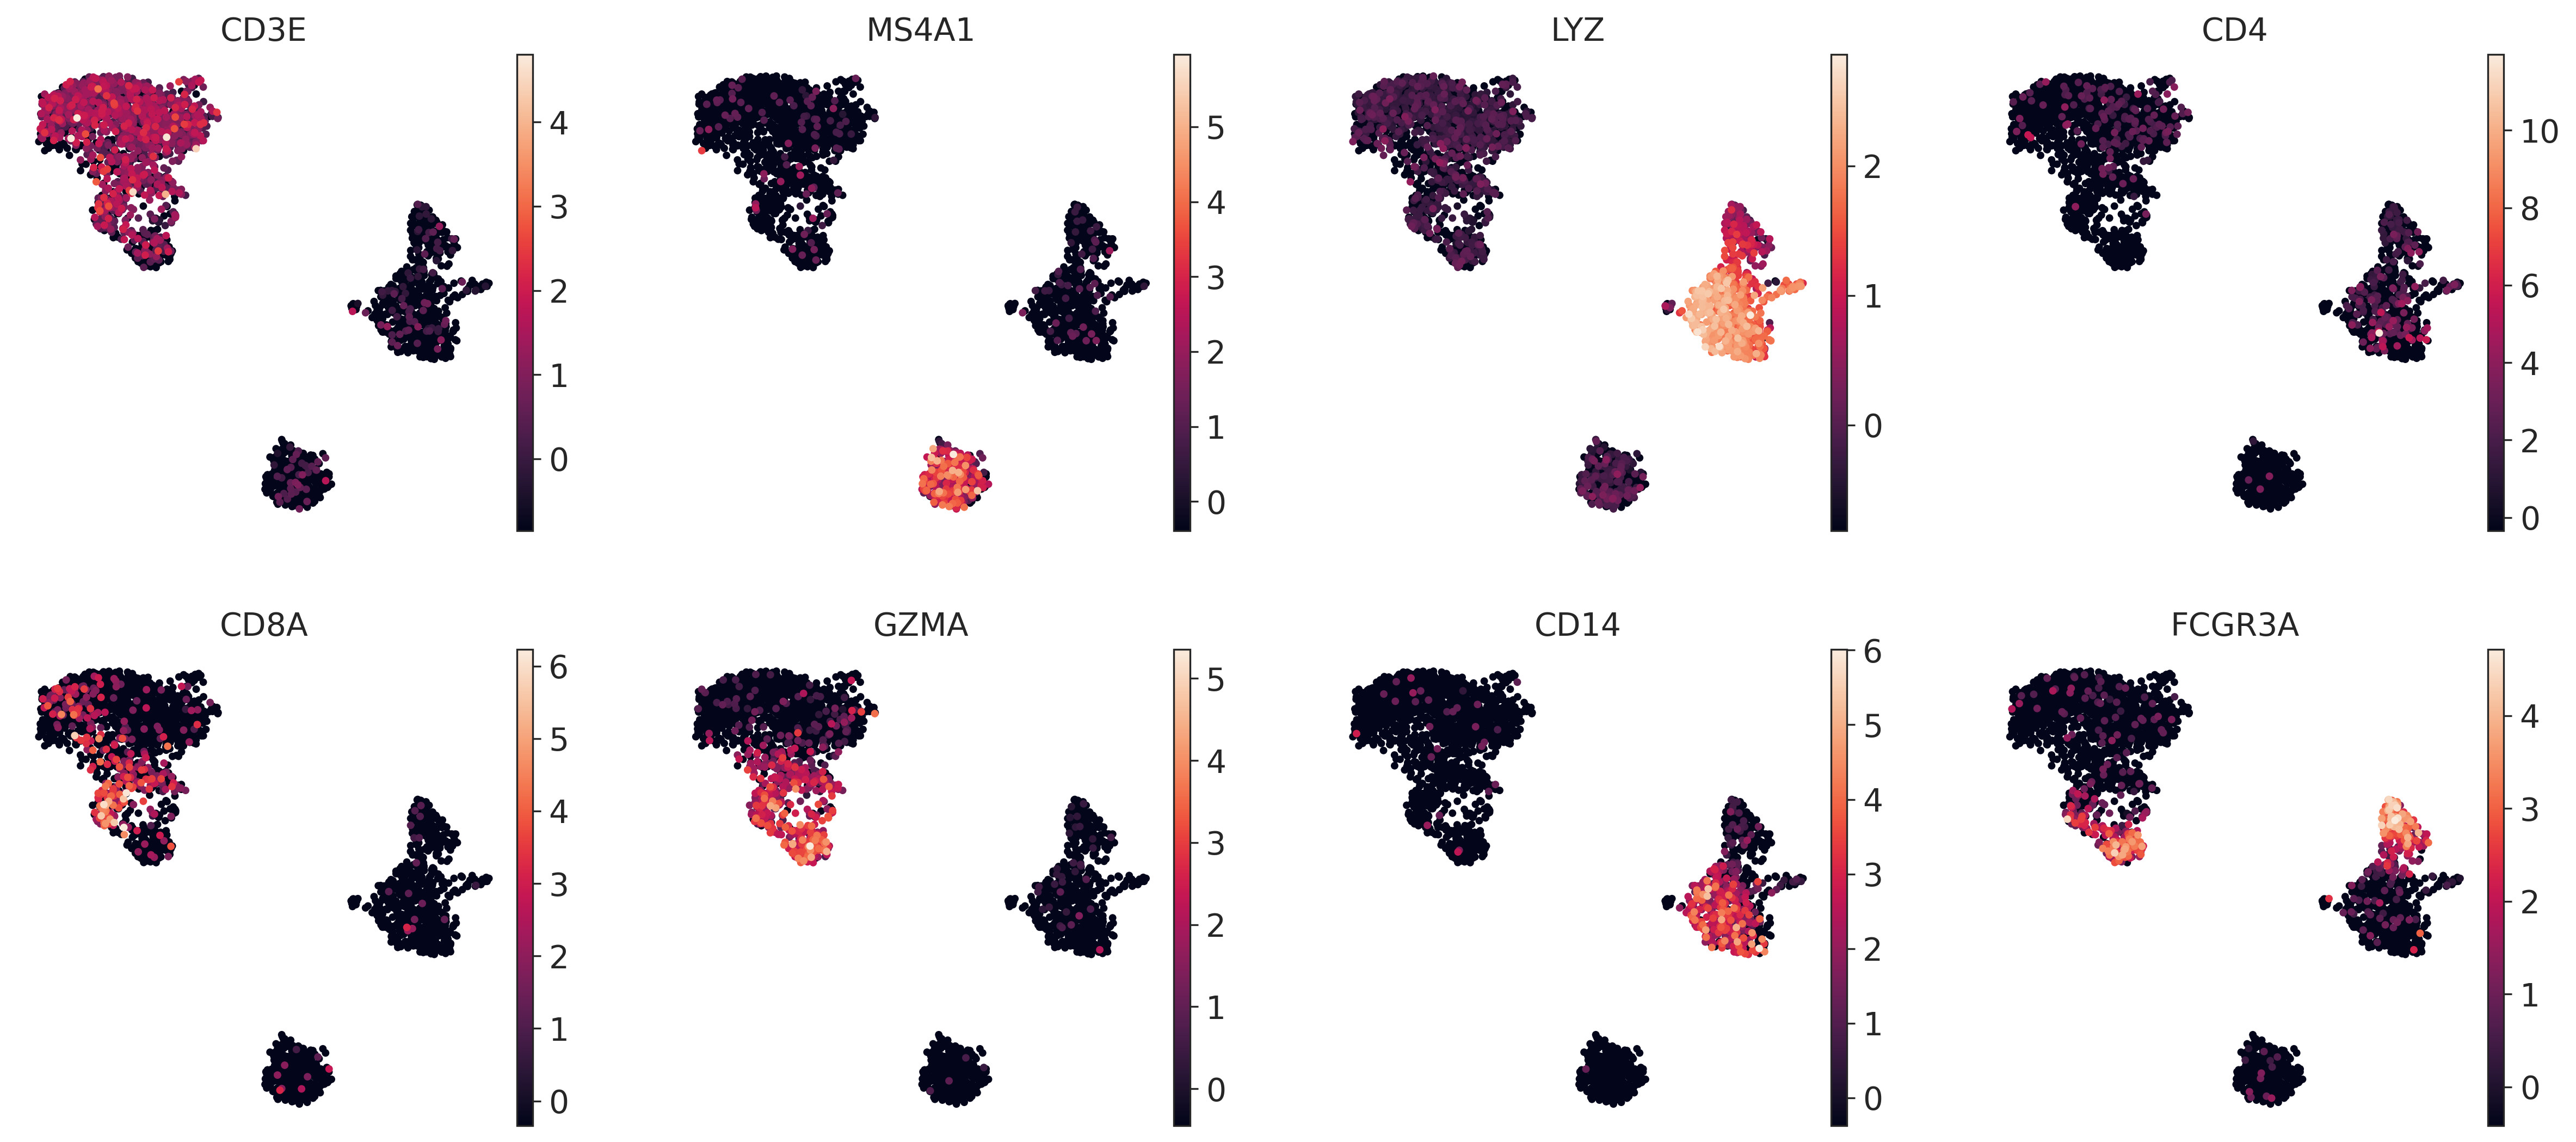

In [ ]:
sc.pl.umap(adata, frameon=False, color=["CD3E", "MS4A1", "LYZ", "CD4", "CD8A", "GZMA", "CD14", "FCGR3A"])

In [ ]:
import pandas as pd

pred = pd.read_csv("azimuth_pred.tsv", sep="\t", index_col=0)
pred.head()

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

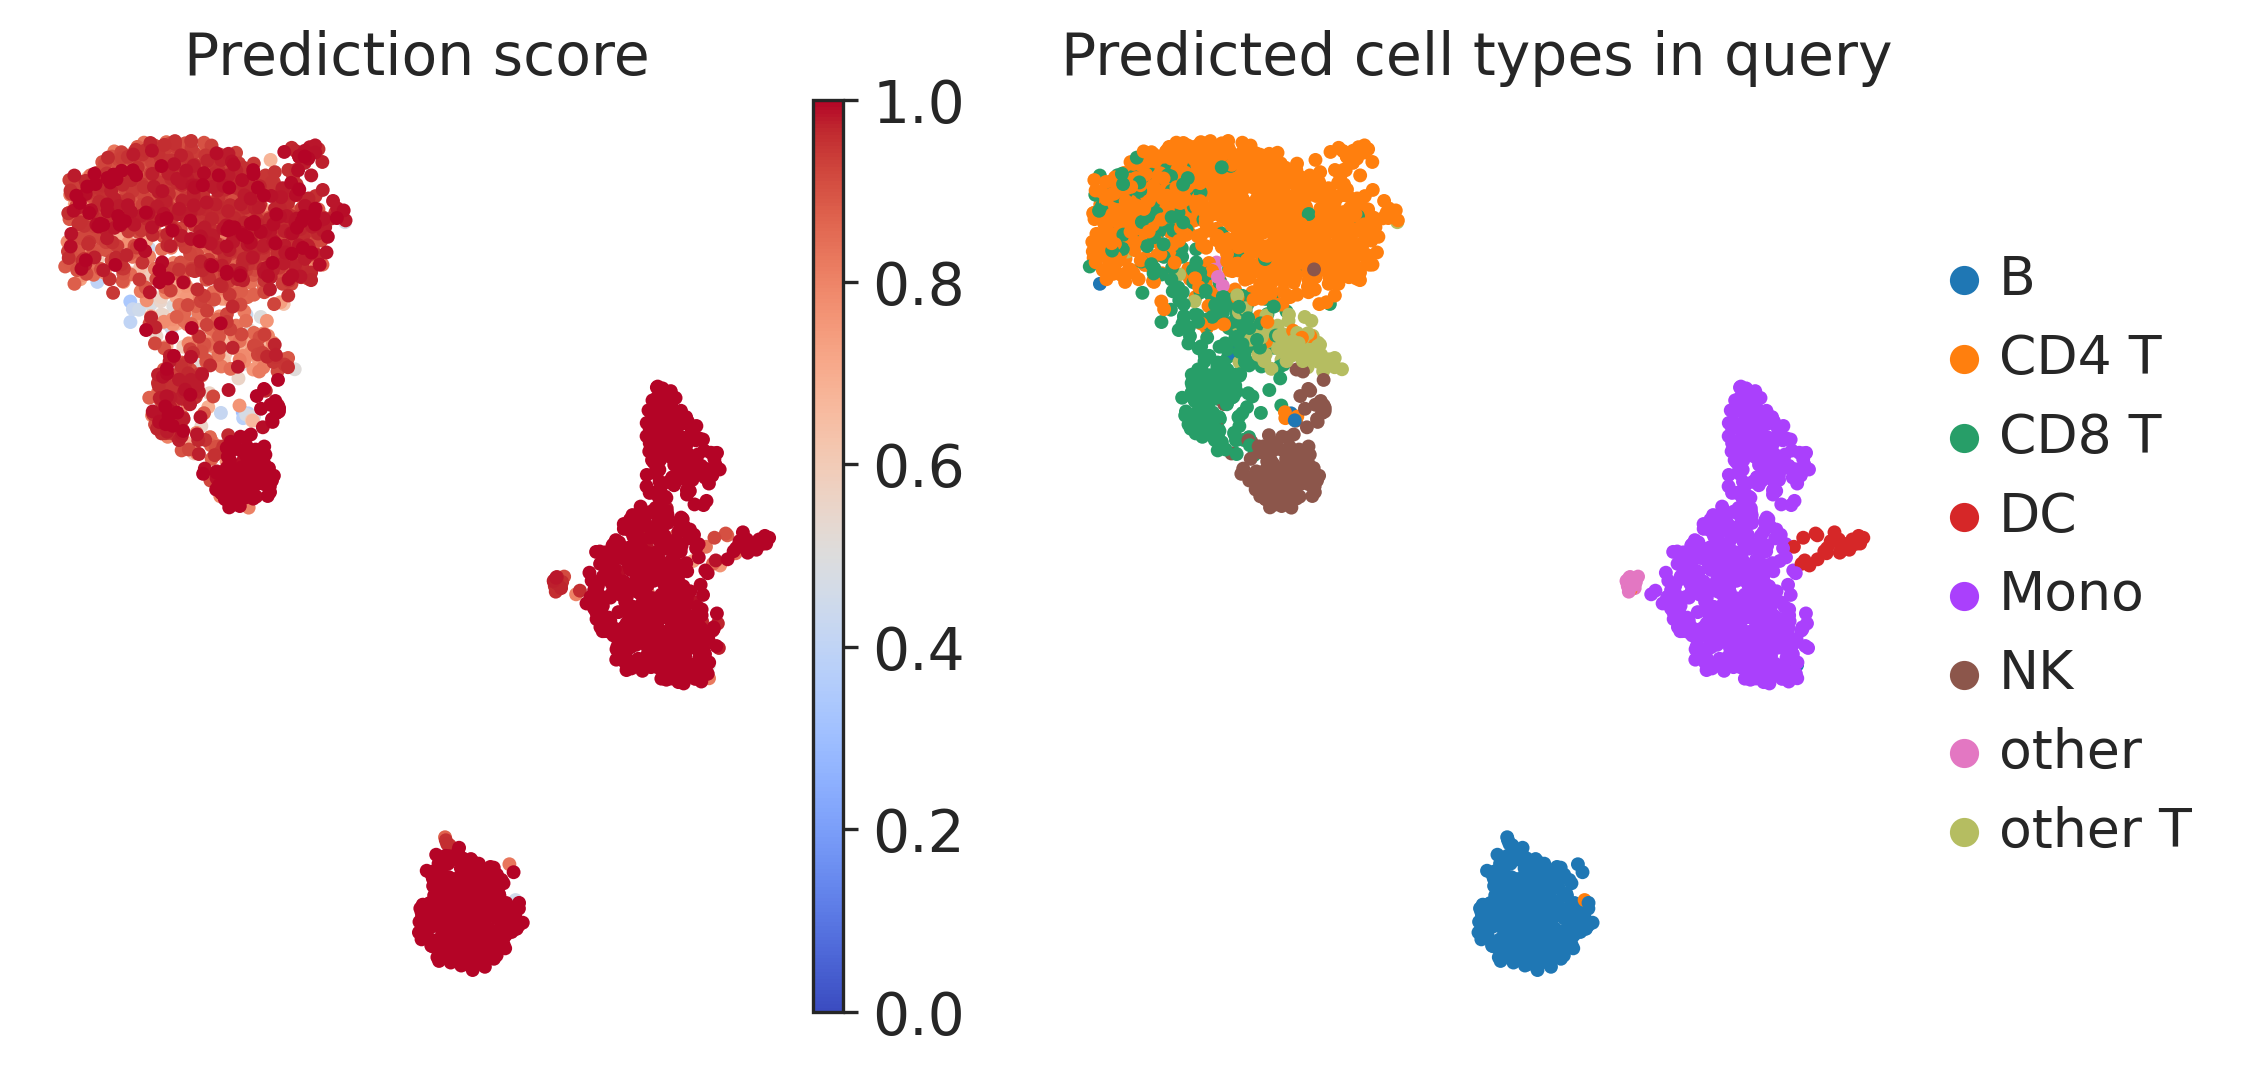

In [ ]:
adata.obs["celltype_l1_predicted"] = pred.loc[adata.obs_names]["predicted.celltype.l1"]
adata.obs["l1_prediction_score"] = pred.loc[adata.obs_names]["predicted.celltype.l1.score"]

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata, color="celltype_l1_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata, color="l1_prediction_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

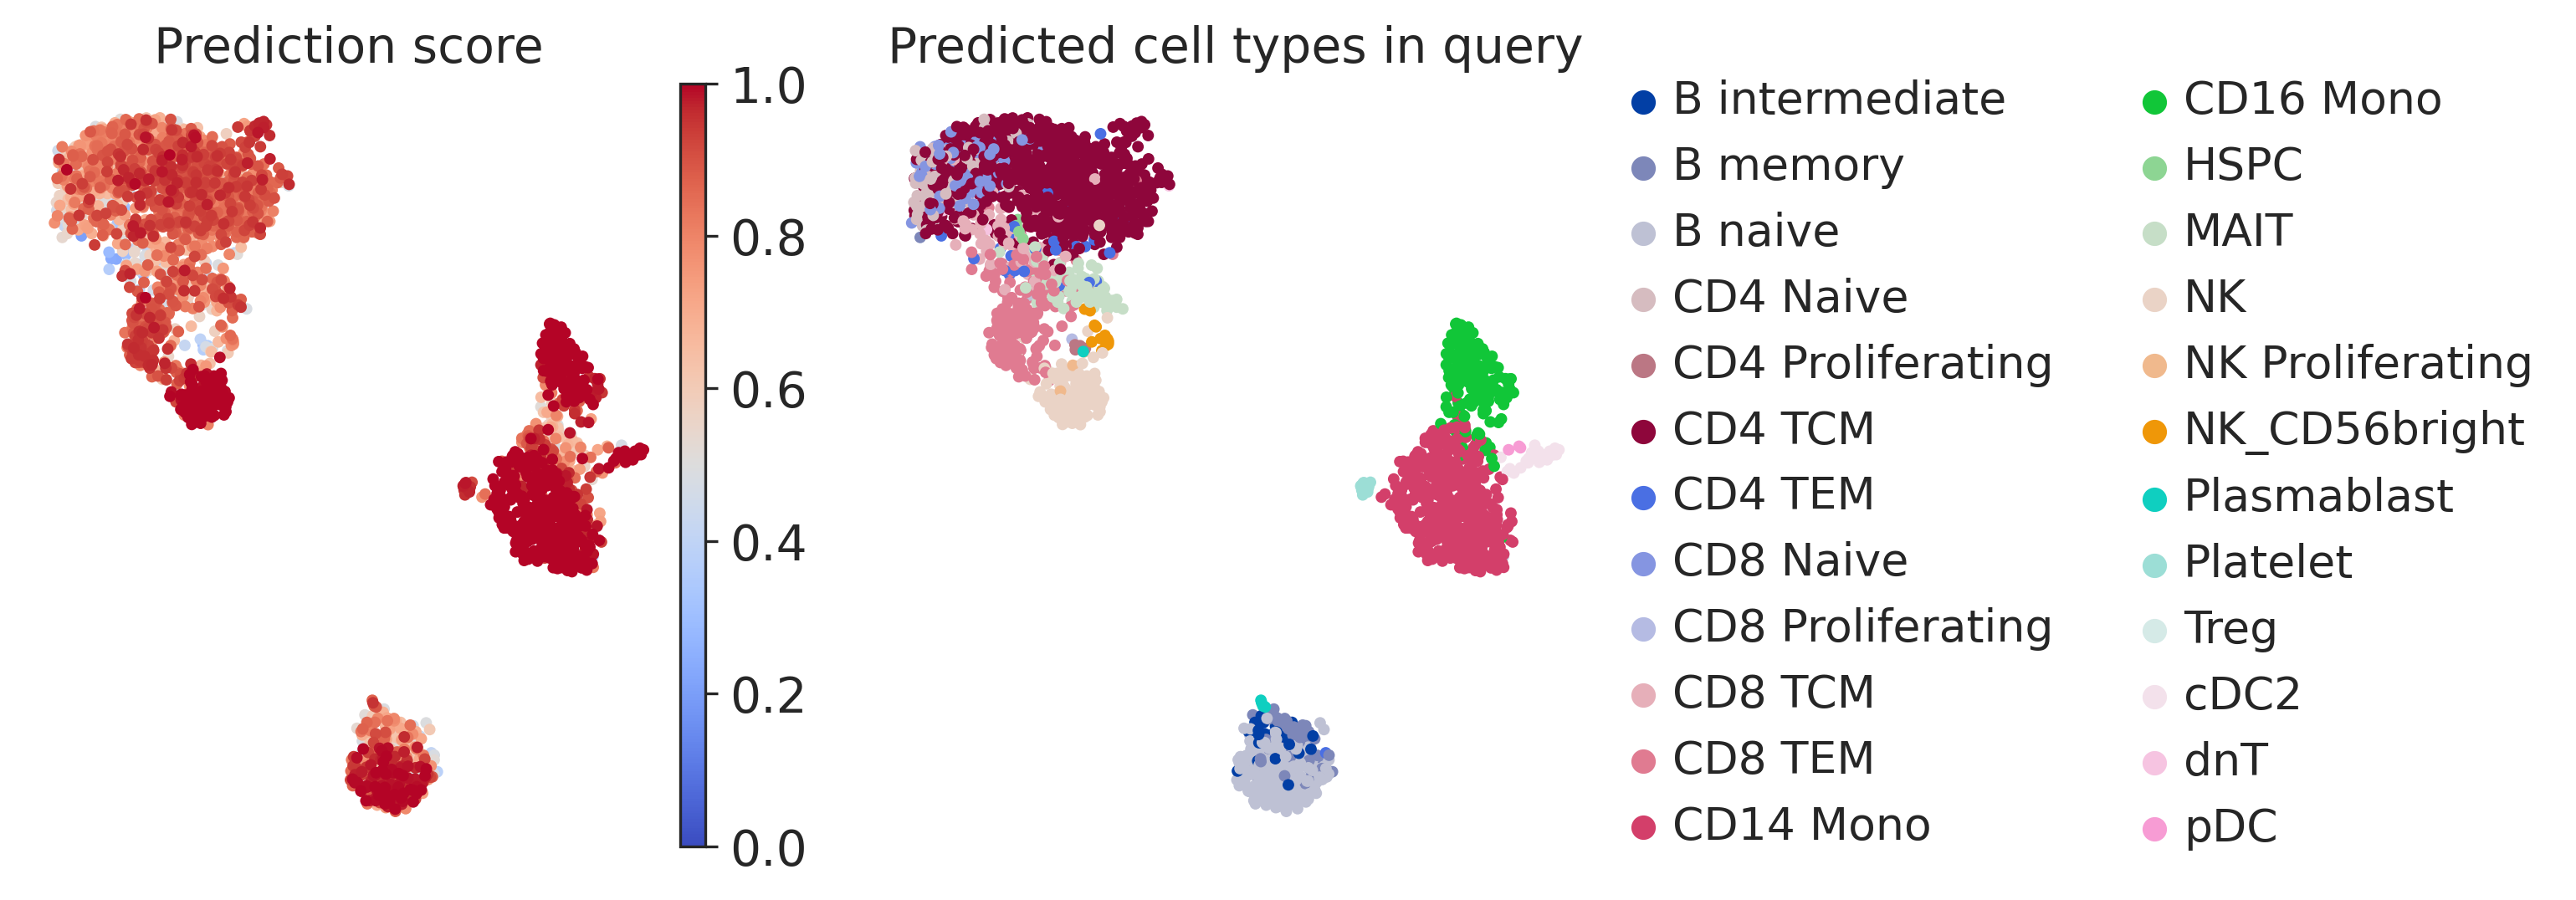

In [ ]:
adata.obs["celltype_l2_predicted"] = pred.loc[adata.obs_names]["predicted.celltype.l2"]
adata.obs["l2_prediction_score"] = pred.loc[adata.obs_names]["predicted.celltype.l2.score"]

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata, color="celltype_l2_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata, color="l2_prediction_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

## Написание алгоритма на основе Harmony

Попробуем самостоятельно написать алгоритм, который определяет типы клеток. Для этого сначала загрузим датасет с известной аннотацией (воспользуемся тем, что у нас был в занятии по батч-коррекции).

In [ ]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"
adata_reference = sc.read_h5ad("PBMC_Satija.h5ad")
adata_reference.layers["counts"] = adata_reference.X.copy()
adata_reference.obs["ref_query"] = "reference"

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:02<00:00, 108MB/s] 


Логика автоматической аннотации будет примерно следующей: давайте попробуем интегрировать исходный датасет с референсным, после чего проаннотировать по ближайшим клеткам в интегрированном датасете ту часть, про которую мы ничего не знаем (просто при помощи kNN-классификатора). Сначала создадим общий AnnData-объект:

In [ ]:
adata = sc.datasets.pbmc3k()
adata.obs["ref_query"] = "query"
adata.obs["donor"] = "query"
adata.obs.index = [f"{bc.split('-')[0]}:query" for bc in adata.obs.index]
adata_reference.obs.index = [f"{bc.split('_')[1]}:{bc.split('_')[0]}" for bc in adata_reference.obs.index]

In [ ]:
adata_concat = adata.concatenate(adata_reference, index_unique=None)
adata_concat.layers["counts"] = adata_concat.X.copy()
del adata_concat.obs["batch"]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
adata_concat.obs.head()

ref_query  donor orig.ident lane time celltype.l1  \
AAACATACAACCAC:query     query  query        NaN  NaN  NaN         NaN   
AAACATTGAGCTAC:query     query  query        NaN  NaN  NaN         NaN   
AAACATTGATCAGC:query     query  query        NaN  NaN  NaN         NaN   
AAACCGTGCTTCCG:query     query  query        NaN  NaN  NaN         NaN   
AAACCGTGTATGCG:query     query  query        NaN  NaN  NaN         NaN   

                     celltype.l2 celltype.l3 Phase  
AAACATACAACCAC:query         NaN         NaN   NaN  
AAACATTGAGCTAC:query         NaN         NaN   NaN  
AAACATTGATCAGC:query         NaN         NaN   NaN  
AAACCGTGCTTCCG:query         NaN         NaN   NaN  
AAACCGTGTATGCG:query         NaN         NaN   NaN

In [ ]:
adata_concat.obs.tail()

ref_query donor orig.ident lane time celltype.l1  \
TTTGTTGGTACGATCT:L5  reference    P2       P2_3   L5    3          NK   
TTTGTTGGTGGTCTGC:L5  reference    P1       P1_0   L5    0        Mono   
TTTGTTGTCAACACCA:L5  reference    P2       P2_3   L5    3        Mono   
TTTGTTGTCATGCATG:L5  reference    P2       P2_3   L5    3       CD8 T   
TTTGTTGTCTGTGCAA:L5  reference    P3       P3_3   L5    3       CD4 T   

                    celltype.l2 celltype.l3 Phase  
TTTGTTGGTACGATCT:L5          NK        NK_2    G1  
TTTGTTGGTGGTCTGC:L5   CD14 Mono   CD14 Mono    G1  
TTTGTTGTCAACACCA:L5   CD14 Mono   CD14 Mono    G1  
TTTGTTGTCATGCATG:L5   CD8 Naive   CD8 Naive    G1  
TTTGTTGTCTGTGCAA:L5     CD4 TCM   CD4 TCM_1    G1

Теперь проведём интеграцию при помощи Harmony:

In [ ]:
import scanpy.external as sce

sc.pp.normalize_total(adata_concat)
sc.pp.log1p(adata_concat)

sc.pp.highly_variable_genes(
    adata_concat,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="donor"
)

sc.pp.scale(adata_concat)
sc.tl.pca(adata_concat)

sc.external.pp.harmony_integrate(adata_concat, key="donor", max_iter_harmony=20)

sc.pp.neighbors(
    adata_concat,
    use_rep="X_pca_harmony",
    n_pcs=30
)

sc.tl.umap(adata_concat)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)


2022-12-26 11:42:54,415 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2022-12-26 11:43:11,830 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2022-12-26 11:43:12,058 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2022-12-26 11:43:25,792 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2022-12-26 11:43:36,693 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2022-12-26 11:43:47,566 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2022-12-26 11:43:58,506 - harmonypy - INFO - Iteration 5 of 20
INFO:harmonypy:Iteration 5 of 20
2022-12-26 11:44:09,767 - harmonypy - INFO - Iteration 6 of 20
INFO:harmonypy:Iteration 6 of 20
2022-12-26 11:44:20,999 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Cell type'}, xlabel='UMAP1', ylabel='UMAP2'>

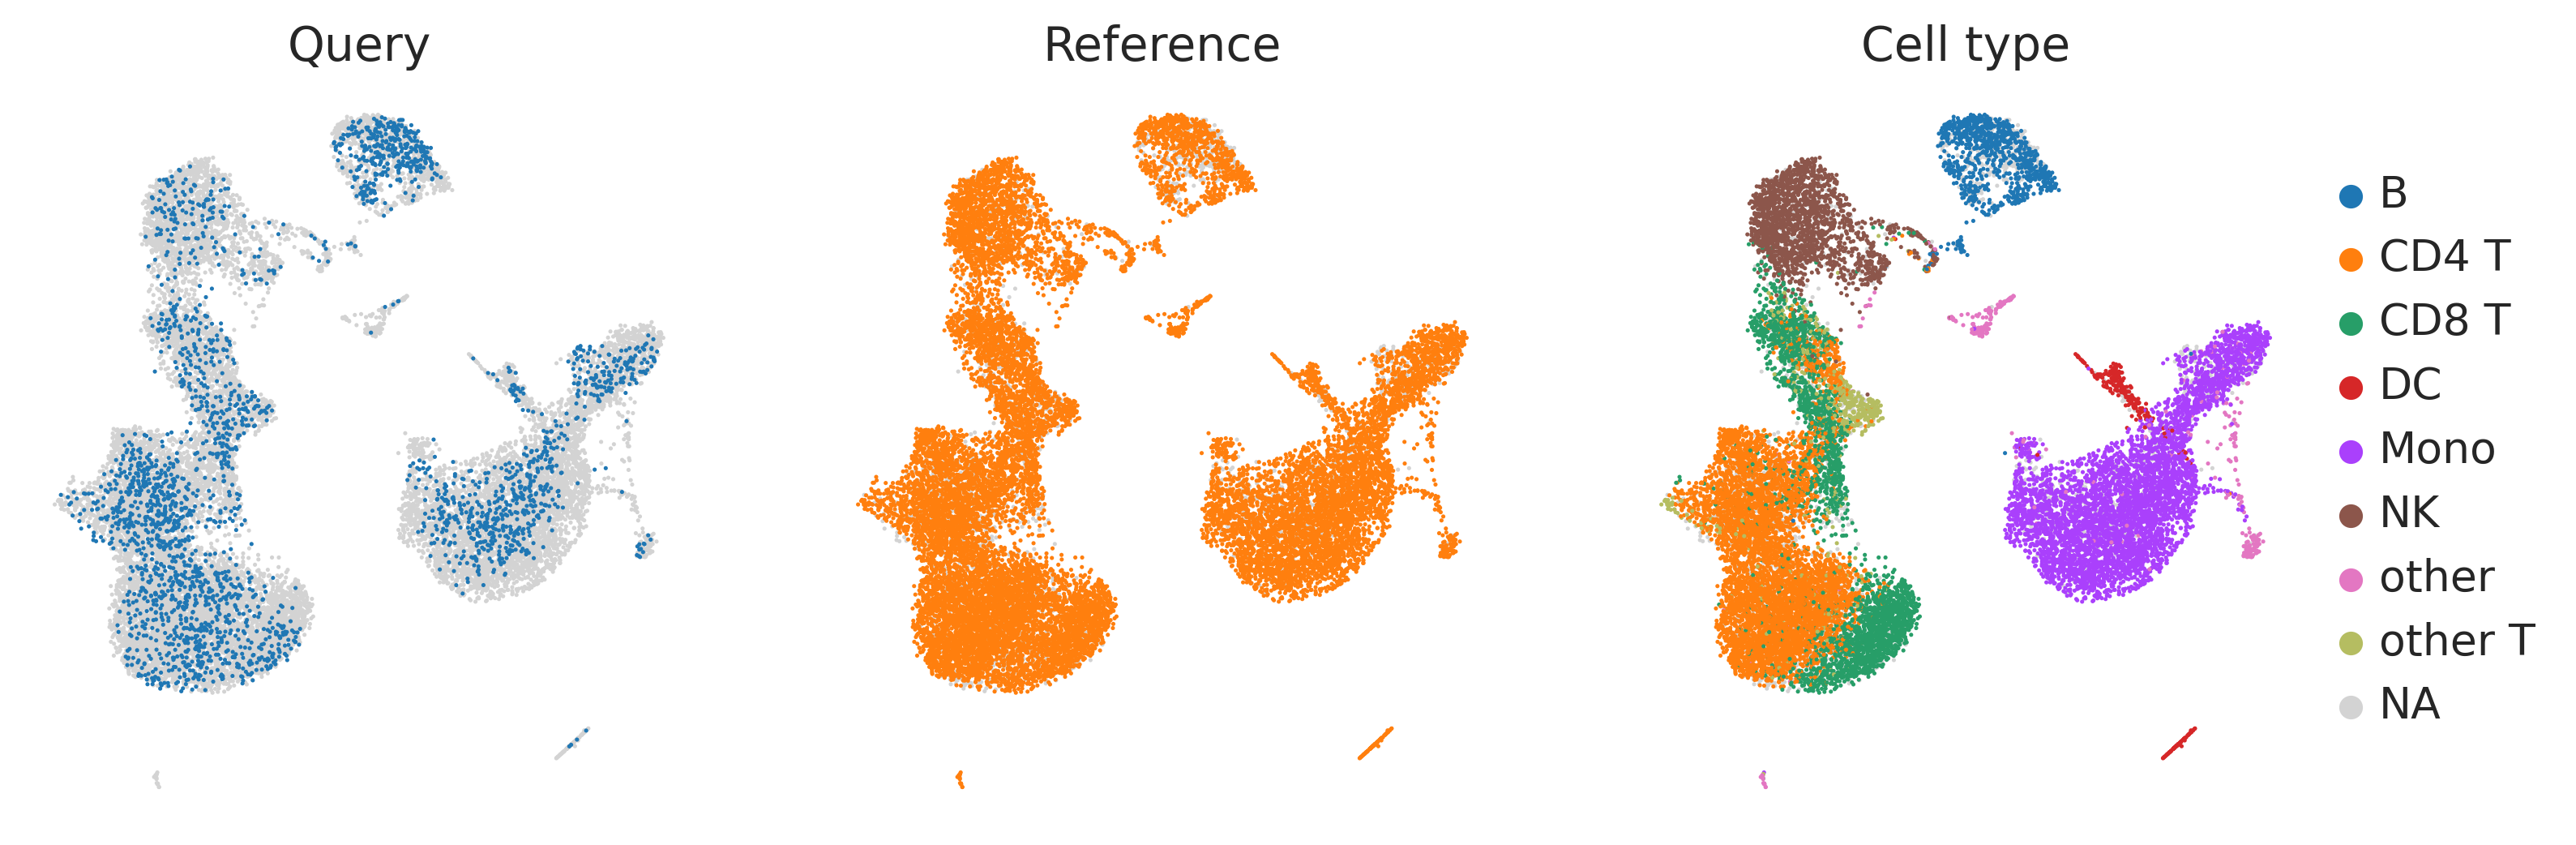

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(12, 4), ncols=3, dpi=150)

sc.pl.umap(adata_concat, color="ref_query", groups=["query"], frameon=False, legend_loc=None, title="Query", ax=axes[0], show=False)
sc.pl.umap(adata_concat, color="ref_query", groups=["reference"], frameon=False, legend_loc=None, title="Reference", ax=axes[1], show=False)
sc.pl.umap(adata_concat, color="celltype.l1", frameon=False, title="Cell type", ax=axes[2], show=False)

Теперь давайте проаннотируем каждый из тип клеток в зависимости от того, с какими уже известными проаннотированными клетками он граничит. Сначала построим новый kNN-граф (в зависимости от того, сколько мы хотим брать ближайших соседей):

In [ ]:
k = 20 # Число соседей для предсказания
sc.pp.neighbors(adata_concat, use_rep="X_pca_harmony", n_pcs=30, n_neighbors=k, key_added="prediction")

computing neighbors
    finished: added to `.uns['prediction']`
    `.obsp['prediction_distances']`, distances for each pair of neighbors
    `.obsp['prediction_connectivities']`, weighted adjacency matrix (0:00:04)


Теперь посмотрим, какие типы клеток (из известных) граничат с кадой из наших клеток в `query` и по ним предскажем её тип:


In [ ]:
adata_concat.obs["celltype.l1"][adata_concat.obsp["prediction_distances"][1].A[0] > 0]

ACCGTGCTGGAACG:query    NaN
ACTGAGACGTTGGT:query    NaN
AGATATACTGTTCT:query    NaN
CGCGAGACAGGTCT:query    NaN
GGAGCCACCTTCTA:query    NaN
TATGGGTGCTAGCA:query    NaN
TTAGTCTGAAAGCA:query    NaN
AAGGTAATCATGCATG:L1       B
AACCCAACACGATTCA:L2       B
AGCCAATTCGTTGTGA:L2       B
CTAAGTGCAACGATCT:L2       B
TCGGATACATCCGTTC:L2       B
TTTGTTGAGGTACAGC:L2       B
AAGACTCCAAGTGACG:L3       B
ACTTATCCAGTAACGG:L3       B
CGTTAGAGTGTATCCA:L3       B
AGTACCACATGGTGGA:L5       B
AGTGACTCAGGTGGAT:L5       B
TGCATCCAGACCATTC:L5       B
Name: celltype.l1, dtype: category
Categories (8, object): ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [ ]:
celltype_predicted = []
prediction_score = []
counter = 0

for bc in adata_concat.obs_names:
  if adata_concat.obs.loc[bc]["ref_query"] == "reference":
    celltype_predicted.append(float("NaN"))
    prediction_score.append(float("NaN"))
  else:
    neighbors_celltype = adata_concat.obs["celltype.l1"][(adata_concat.obsp["prediction_distances"][counter] > 0).A[0]]
    if (~neighbors_celltype.isnull()).sum() == 0:
      celltype_predicted.append("Unknown")
      prediction_score.append(float("NaN"))
    else:
      neighbors_celltype = neighbors_celltype[~neighbors_celltype.isnull()]
      ct = neighbors_celltype.value_counts().index[0]
      score = neighbors_celltype.value_counts()[0] / len(neighbors_celltype)
      prediction_score.append(score)
      celltype_predicted.append(ct)
  counter += 1

adata_concat.obs["celltype_predicted"] = celltype_predicted
adata_concat.obs["prediction_score"] = prediction_score

Теперь отрисуем наши результаты:

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

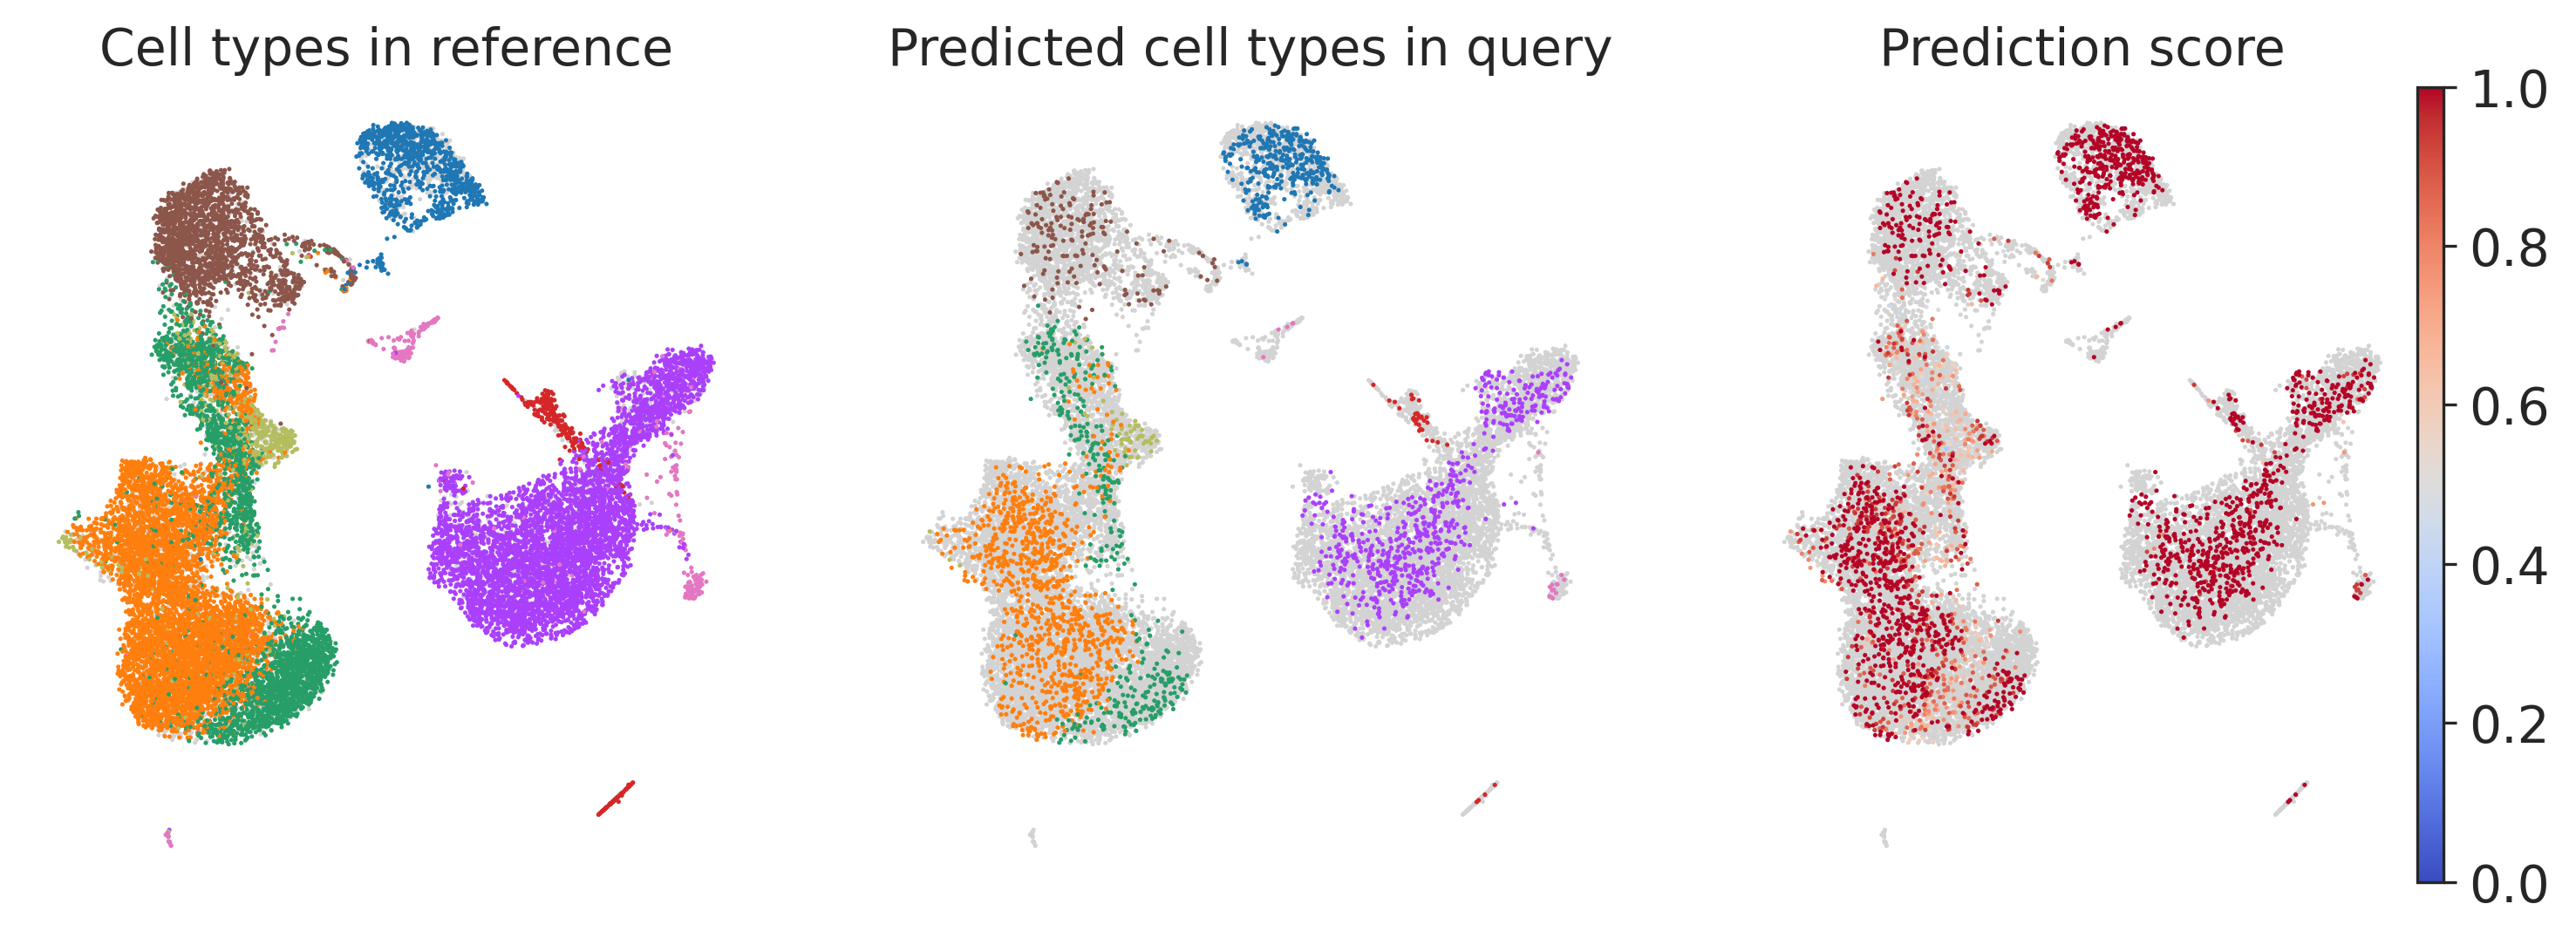

In [ ]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3, dpi=150)

sc.pl.umap(adata_concat, color="celltype.l1", frameon=False, legend_loc=None, title="Cell types in reference", ax=axes[0], show=False)
sc.pl.umap(adata_concat, color="celltype_predicted", frameon=False, legend_loc=None, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata_concat, color="prediction_score", frameon=False, title="Prediction score", ax=axes[2], show=False, cmap="coolwarm", vmin=0, vmax=1)

Теперь спроцессируем наш датасет индивидуально и отрисуем типы клеток на индивидуальном UMAP:

In [ ]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

sc.pp.scale(adata)
sc.tl.pca(adata)

sc.pp.neighbors(
    adata,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [ ]:
adata_concat[adata.obs_names].obs["celltype_predicted"]

AAACATACAACCAC:query    CD8 T
AAACATTGAGCTAC:query        B
AAACATTGATCAGC:query    CD4 T
AAACCGTGCTTCCG:query     Mono
AAACCGTGTATGCG:query       NK
                        ...  
TTTCGAACTCTCAT:query     Mono
TTTCTACTGAGGCA:query        B
TTTCTACTTCCTCG:query        B
TTTGCATGAGAGGC:query        B
TTTGCATGCCTCAC:query    CD4 T
Name: celltype_predicted, Length: 2700, dtype: category
Categories (8, object): ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

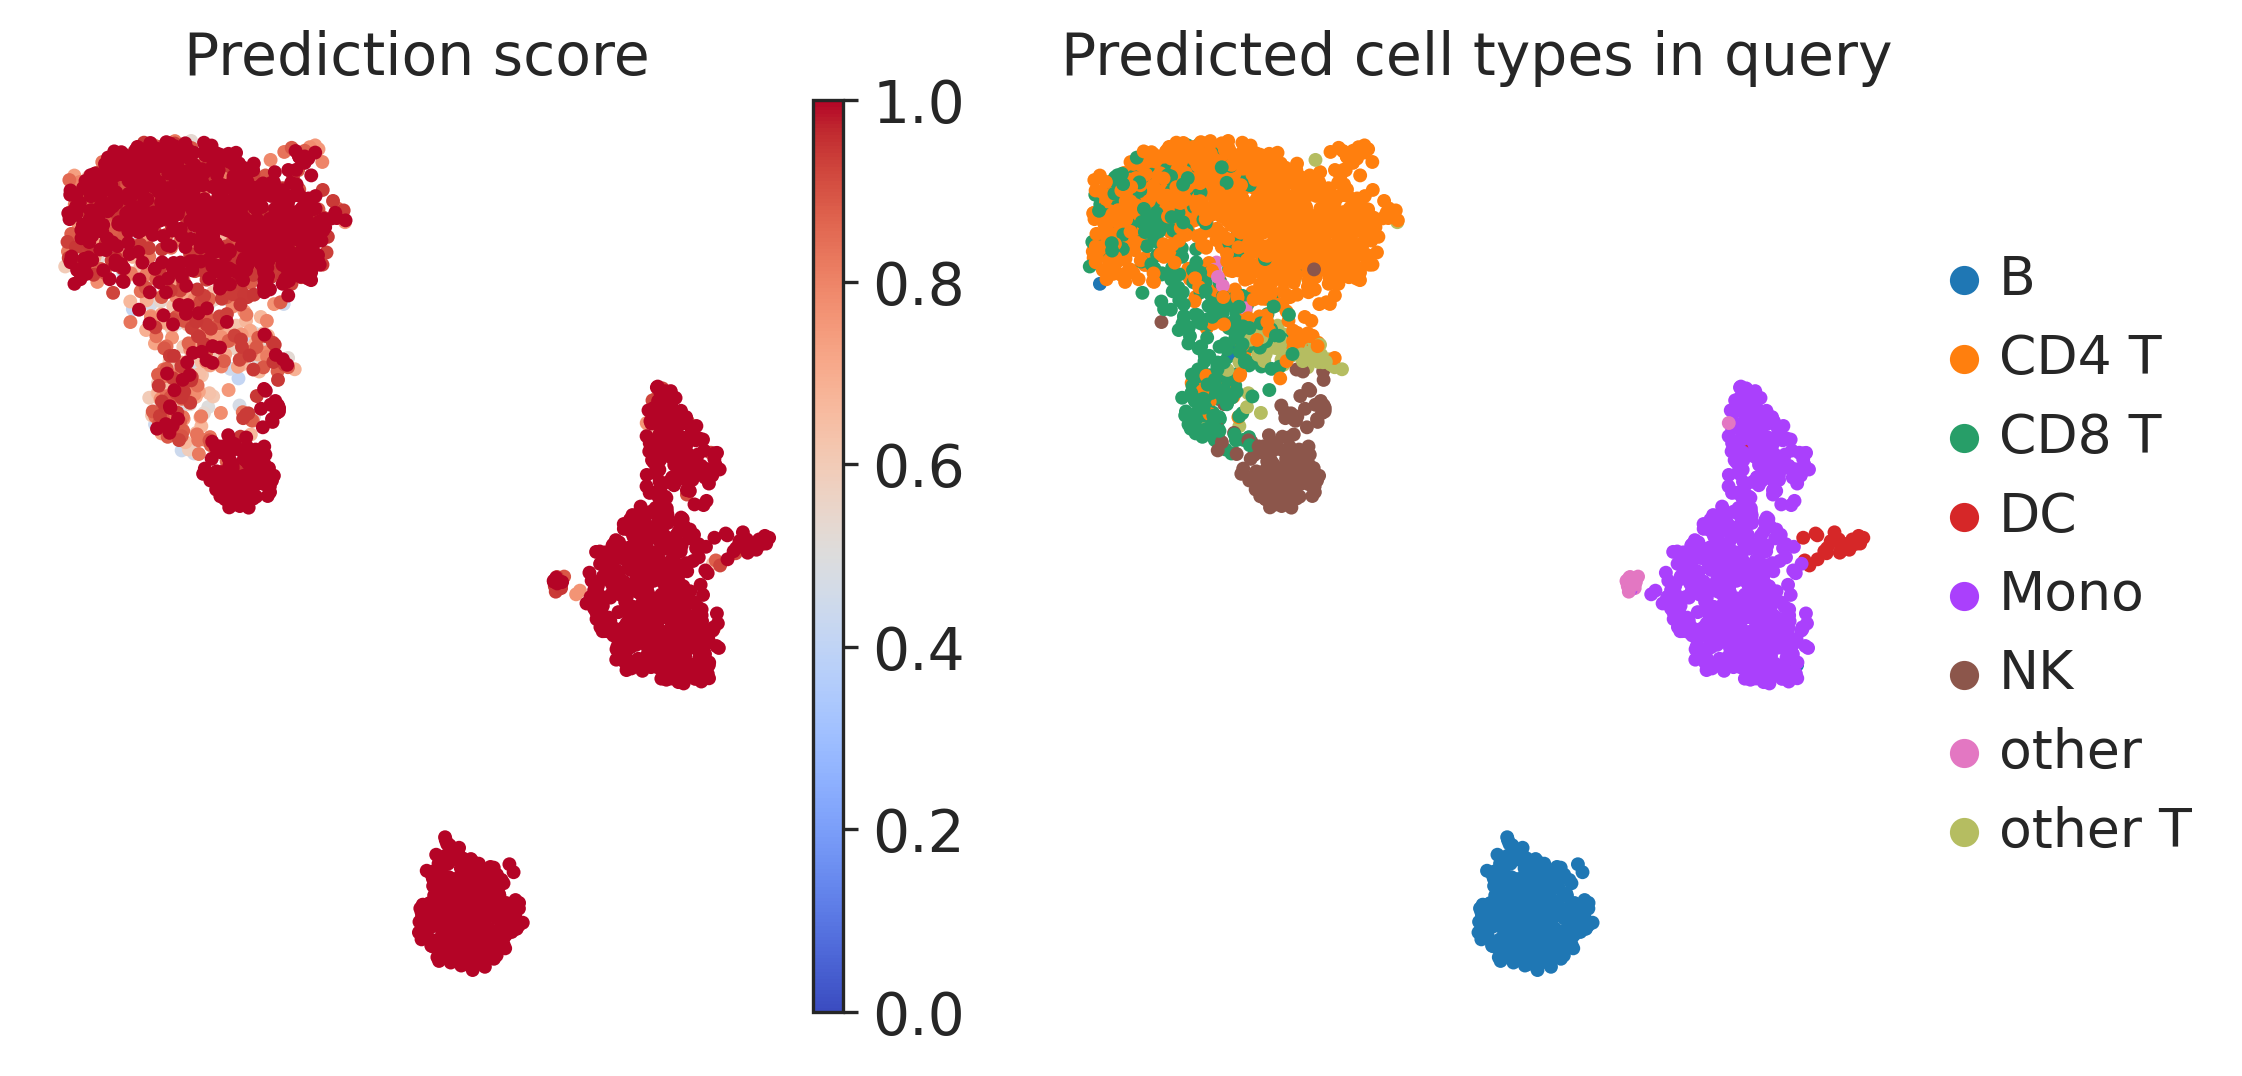

In [ ]:
adata.obs["celltype_predicted"] = list(adata_concat[adata.obs_names].obs["celltype_predicted"])
adata.obs["prediction_score"] = list(adata_concat[adata.obs_names].obs["prediction_score"])

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata, color="celltype_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata, color="prediction_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

А теперь убедимся в правдоподобности нашей аннотации:

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


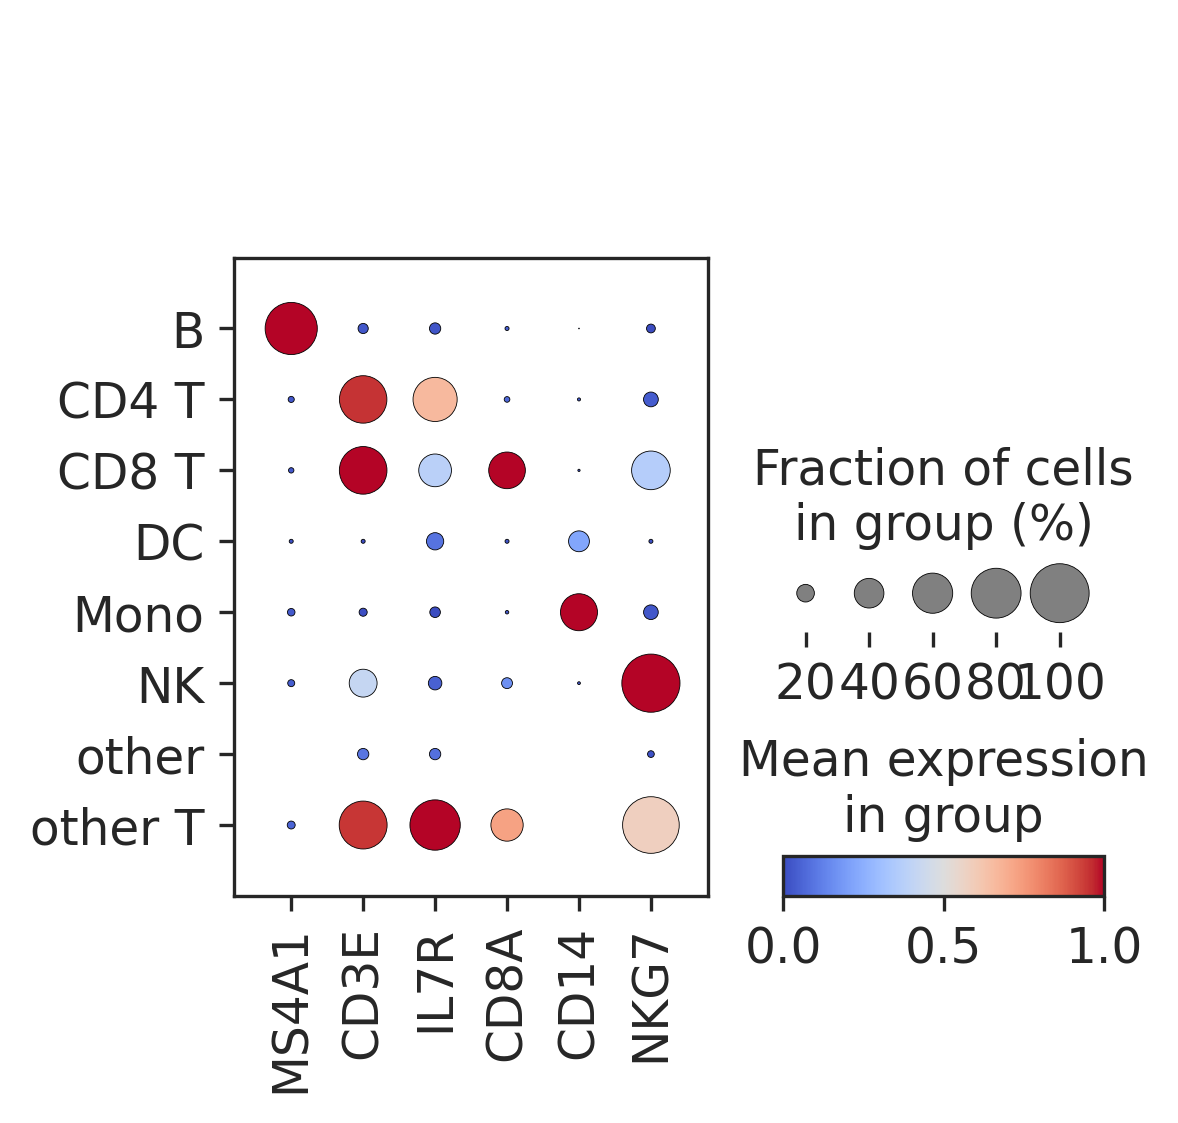

In [ ]:
sc.pl.dotplot(adata, groupby="celltype_predicted", var_names=["MS4A1", "CD3E", "IL7R", "CD8A", "CD14", "NKG7"], standard_scale="var", cmap="coolwarm")

In [ ]:
celltype_predicted = []
prediction_score = []
counter = 0

for bc in adata_concat.obs_names:
  if adata_concat.obs.loc[bc]["ref_query"] == "reference":
    celltype_predicted.append(float("NaN"))
    prediction_score.append(float("NaN"))
  else:
    neighbors_celltype = adata_concat.obs["celltype.l2"][(adata_concat.obsp["prediction_distances"][counter] > 0).A[0]]
    if (~neighbors_celltype.isnull()).sum() == 0:
      celltype_predicted.append("Unknown")
      prediction_score.append(float("NaN"))
    else:
      neighbors_celltype = neighbors_celltype[~neighbors_celltype.isnull()]
      ct = neighbors_celltype.value_counts().index[0]
      score = neighbors_celltype.value_counts()[0] / len(neighbors_celltype)
      prediction_score.append(score)
      celltype_predicted.append(ct)
  counter += 1

adata_concat.obs["celltype_l2_predicted"] = celltype_predicted
adata_concat.obs["prediction_l2_score"] = prediction_score

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

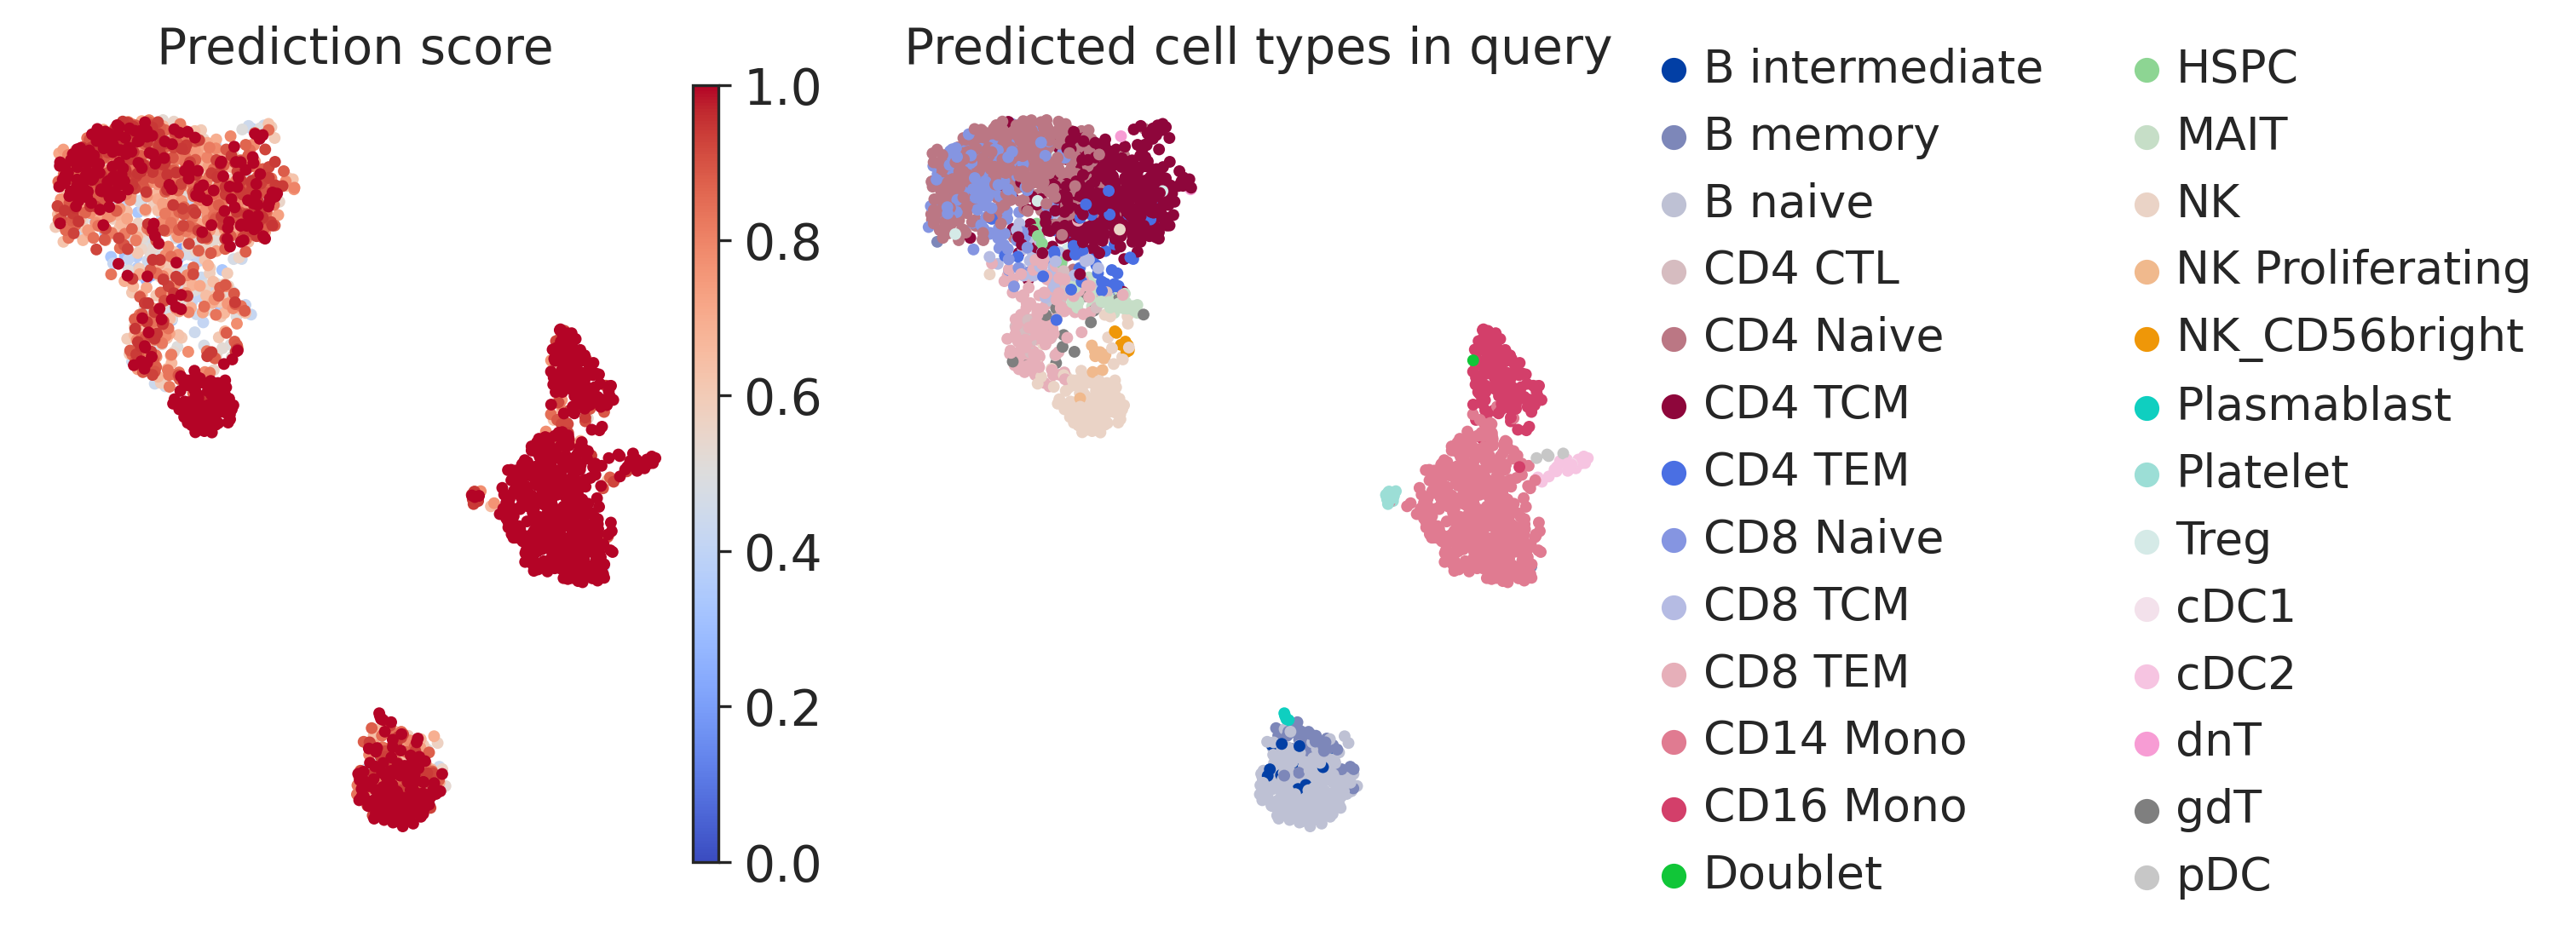

In [ ]:
adata.obs["celltype_l2_predicted"] = list(adata_concat[adata.obs_names].obs["celltype_l2_predicted"])
adata.obs["prediction_l2_score"] = list(adata_concat[adata.obs_names].obs["prediction_l2_score"])

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata, color="celltype_l2_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata, color="prediction_l2_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

## Мануальное определение типов клеток

In [ ]:
adata = sc.datasets.pbmc3k()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

sc.pp.scale(adata)
sc.tl.pca(adata)

sc.pp.neighbors(
    adata,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


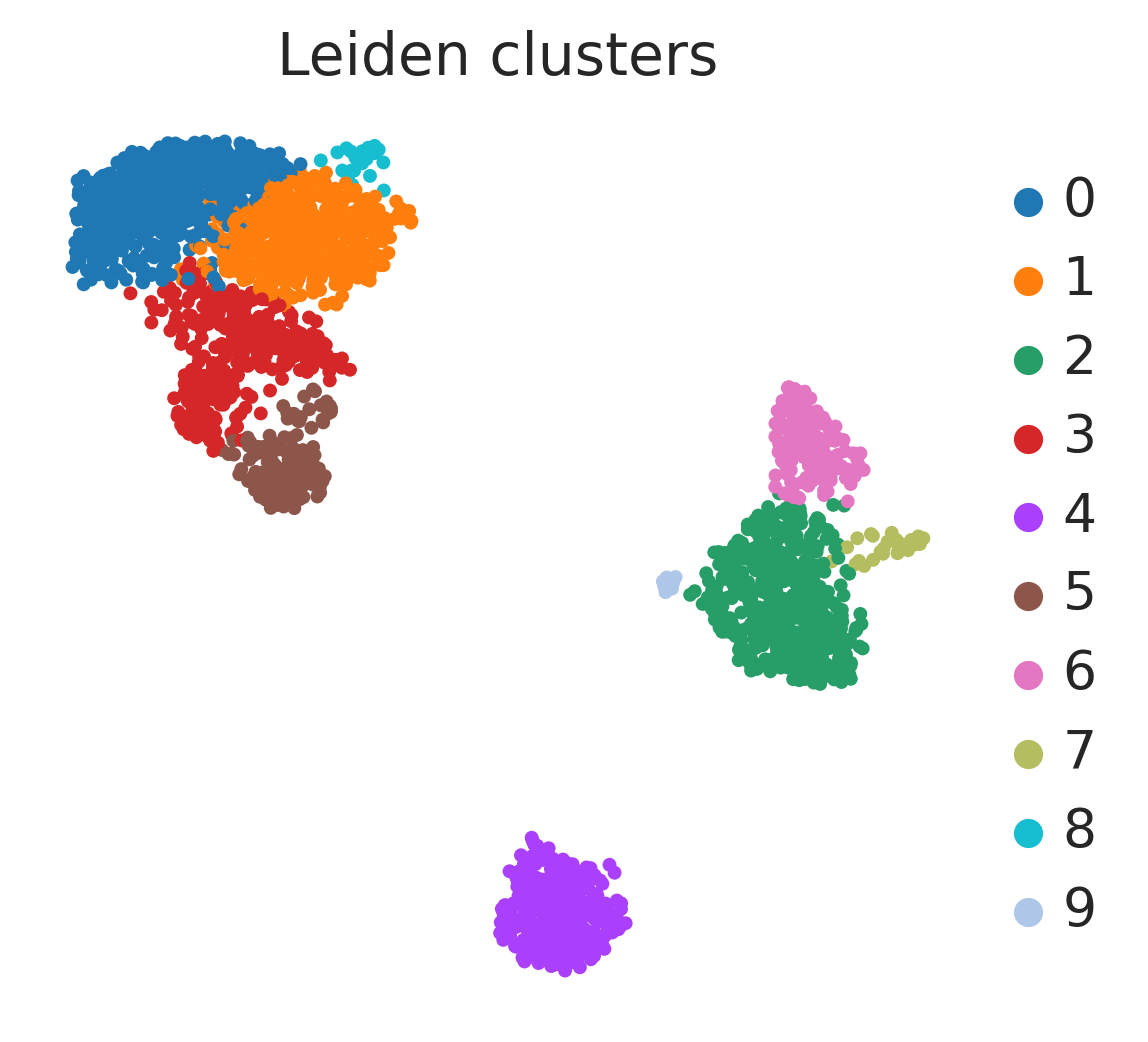

In [ ]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata, color="leiden", title="Leiden clusters", frameon=False)

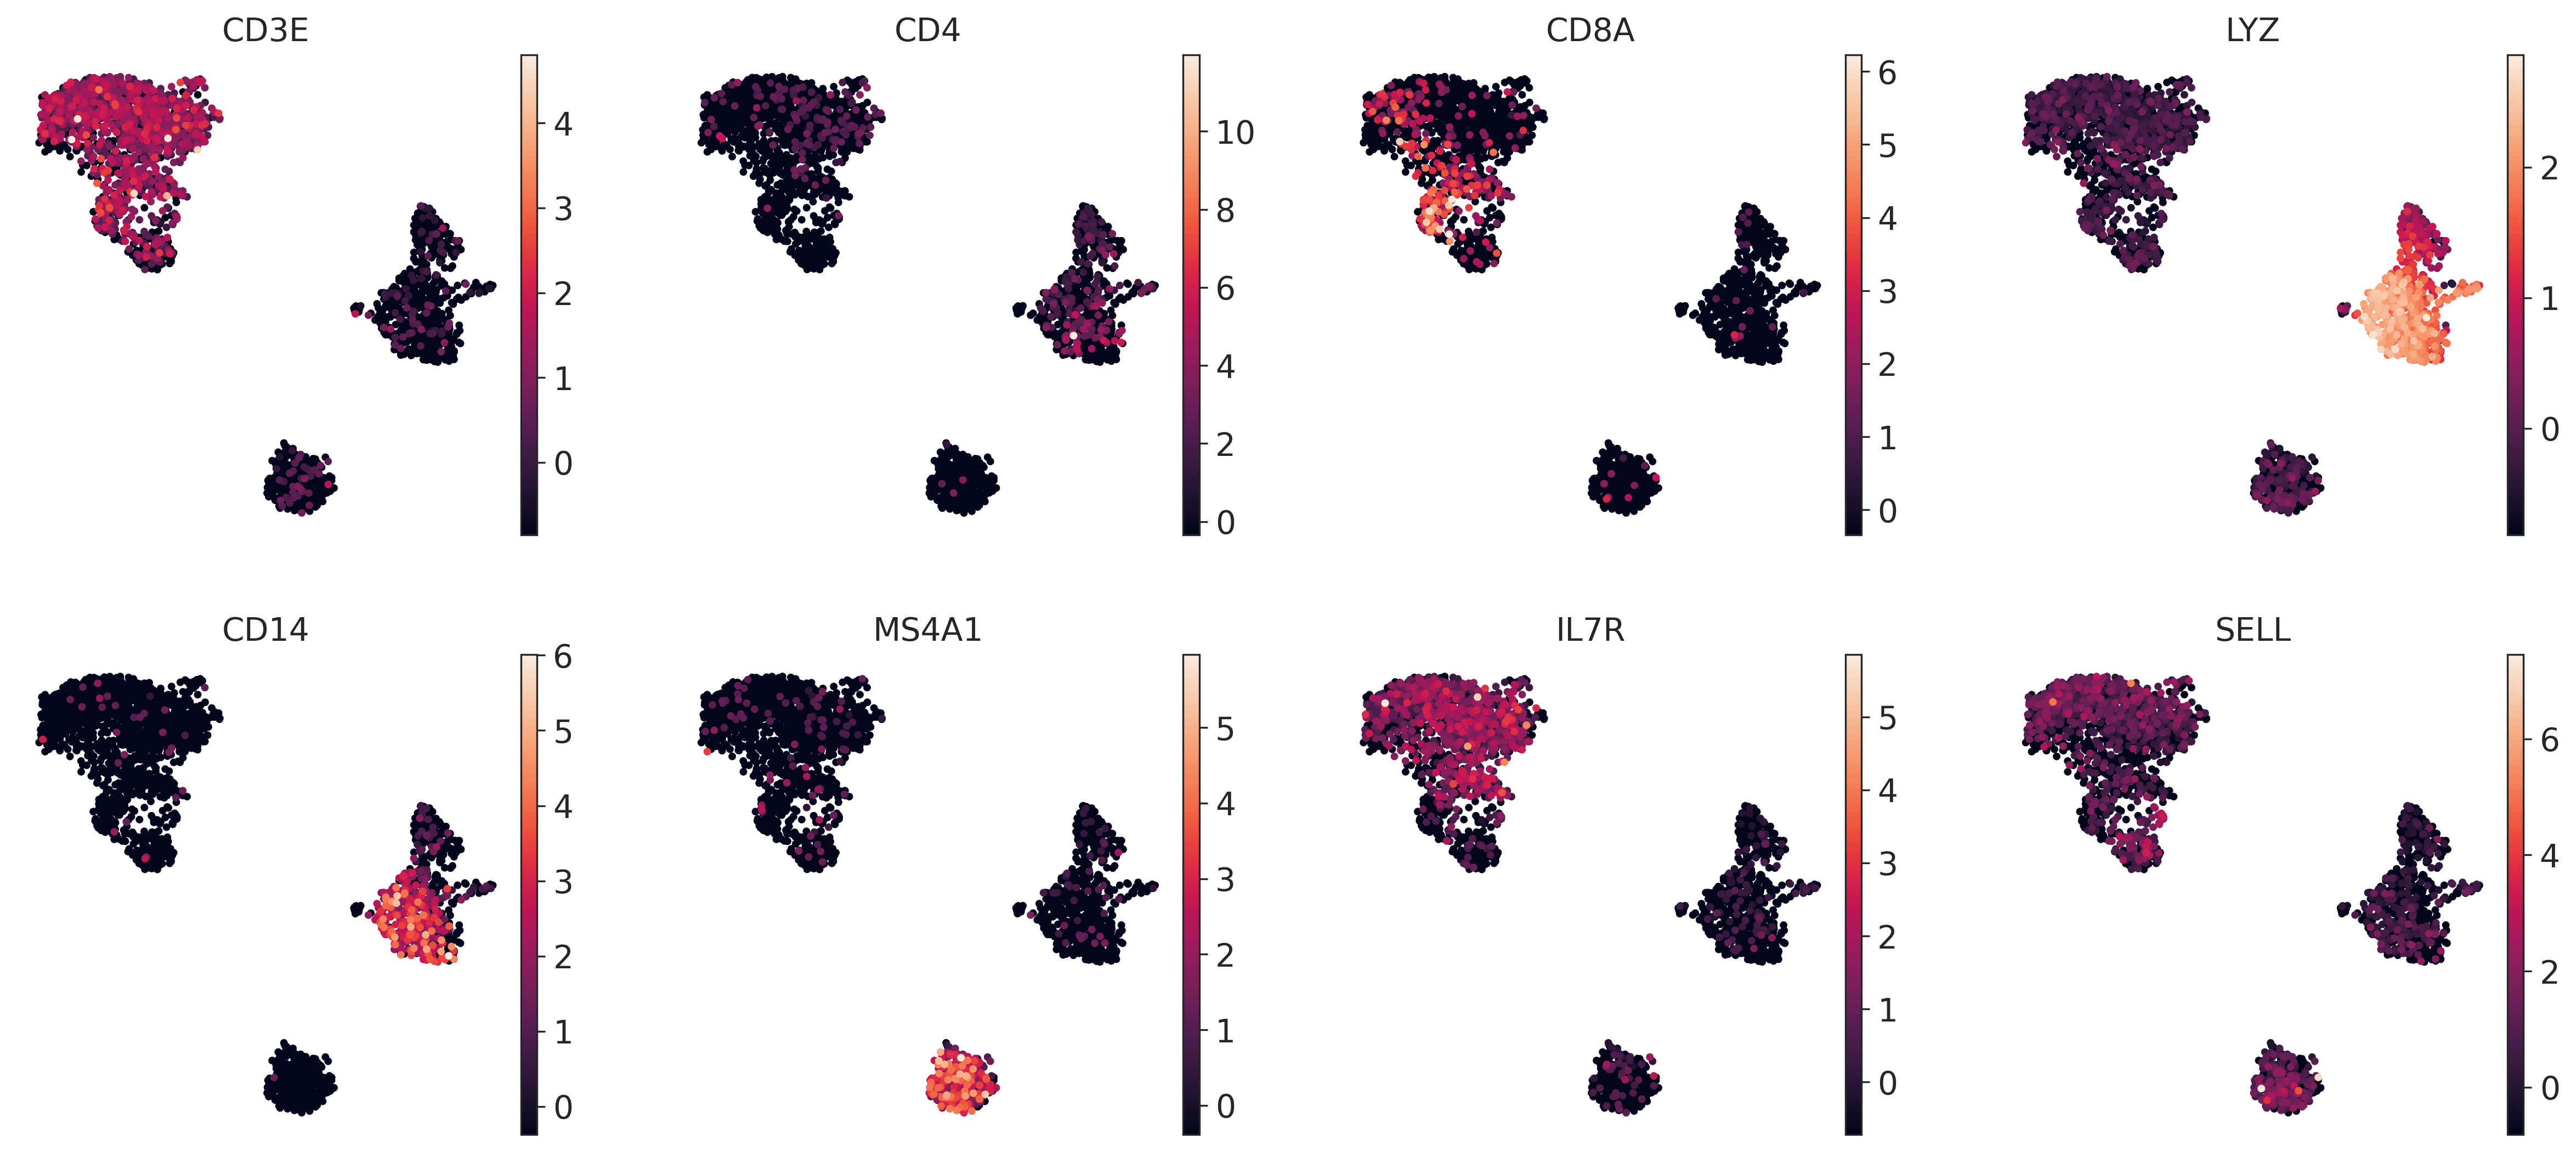

In [ ]:
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "LYZ", "CD14", "MS4A1", "IL7R", "SELL"], frameon=False)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


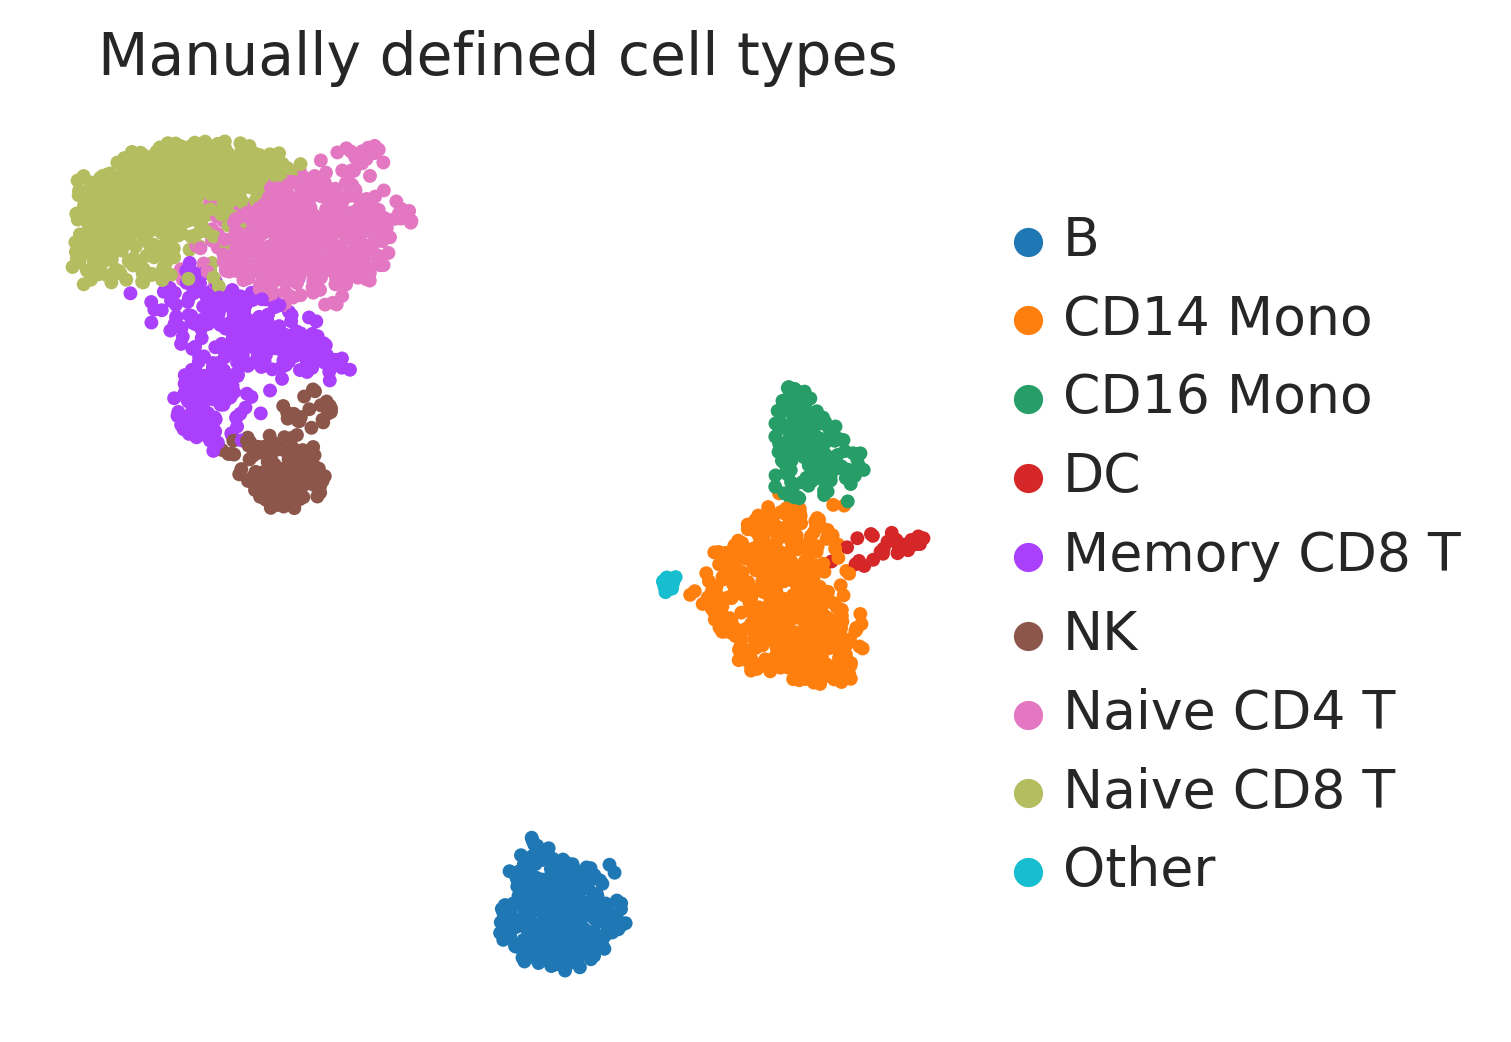

In [ ]:
leiden_to_ct = {
    "0" : "Naive CD8 T",
    "1" : "Naive CD4 T",
    "2" : "CD14 Mono",
    "3" : "Memory CD8 T",
    "4" : "B",
    "5" : "NK",
    "6" : "CD16 Mono",
    "7" : "DC",
    "8" : "Naive CD4 T",
    "9" : "Other"
}

adata.obs["cell_type"] = [leiden_to_ct[leiden] for leiden in adata.obs.leiden]
sc.pl.umap(adata, color="cell_type", title="Manually defined cell types", frameon=False)

## Домашнее задание

*Прочитайте <a href="https://satijalab.github.io/azimuth/articles/run_azimuth_tutorial.html">описание</a> того, как нужно пользоваться Azimuth локально. Попробуйте его запустить локально на датасете из примера. Получилось ли в точности то же, что и в результате работы web-приложения?*

Значится, так. У меня не получилось воспользоваться Azimuth в Google Colab - он либо не скачивается, либо скачивается, однако колаб рушится из-за того, что в процессе работы Azimuth съедает всю RAM. Поэтому, тут прошу меня простить, я воспользовался обходным путём - установил Azimuth на R себе на компьютер и обработал наш датасет не в Colabе, а у себя на компьюктере.


In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

In [ ]:
import anndata2ri
import rpy2.robjects as ro
anndata2ri.activate()
!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

In [ ]:
#Воспользуемся функцией из далёкого шестого семинара
adata.obs["tissue"] = "PBMC"
adata.var["feature_types"] = "Gene Expression"

def save_as_Seurat(ann_file, path = "./"):
  ro.r("library(Seurat)")
  ro.globalenv["adata"] = ann_file
  ro.globalenv["path"] = path+'out.rds'
  df = ro.r('out <- as.Seurat(adata,data = NULL, counts = "X")')
  ro.r('saveRDS(out,file = path)')
  return 

save_as_Seurat(adata)

Код в R выглядит следующим образом:
```
target <- readRDS("/home/eegorov/transcriptomics/out.rds")
target <- RenameAssays(object = target, originalexp = 'RNA')
pbmcsca <- RunAzimuth(target, reference = "pbmcref")

metadata <- pbmcsca@meta.data %>% 
  select(starts_with("predict"))
  
write.csv(metadata,file="./azimuth_local.csv")
```


Соединим наши предсказания с данными и посмотрим, что получилось




In [81]:
import pandas as pd 
pred = pd.read_csv("azimuth_local.csv", sep=",", index_col=0)
pred.head()
new_index = pred.index
new_index = [new.split(":")[0]+"-1" for new in new_index]
pred.index = new_index

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

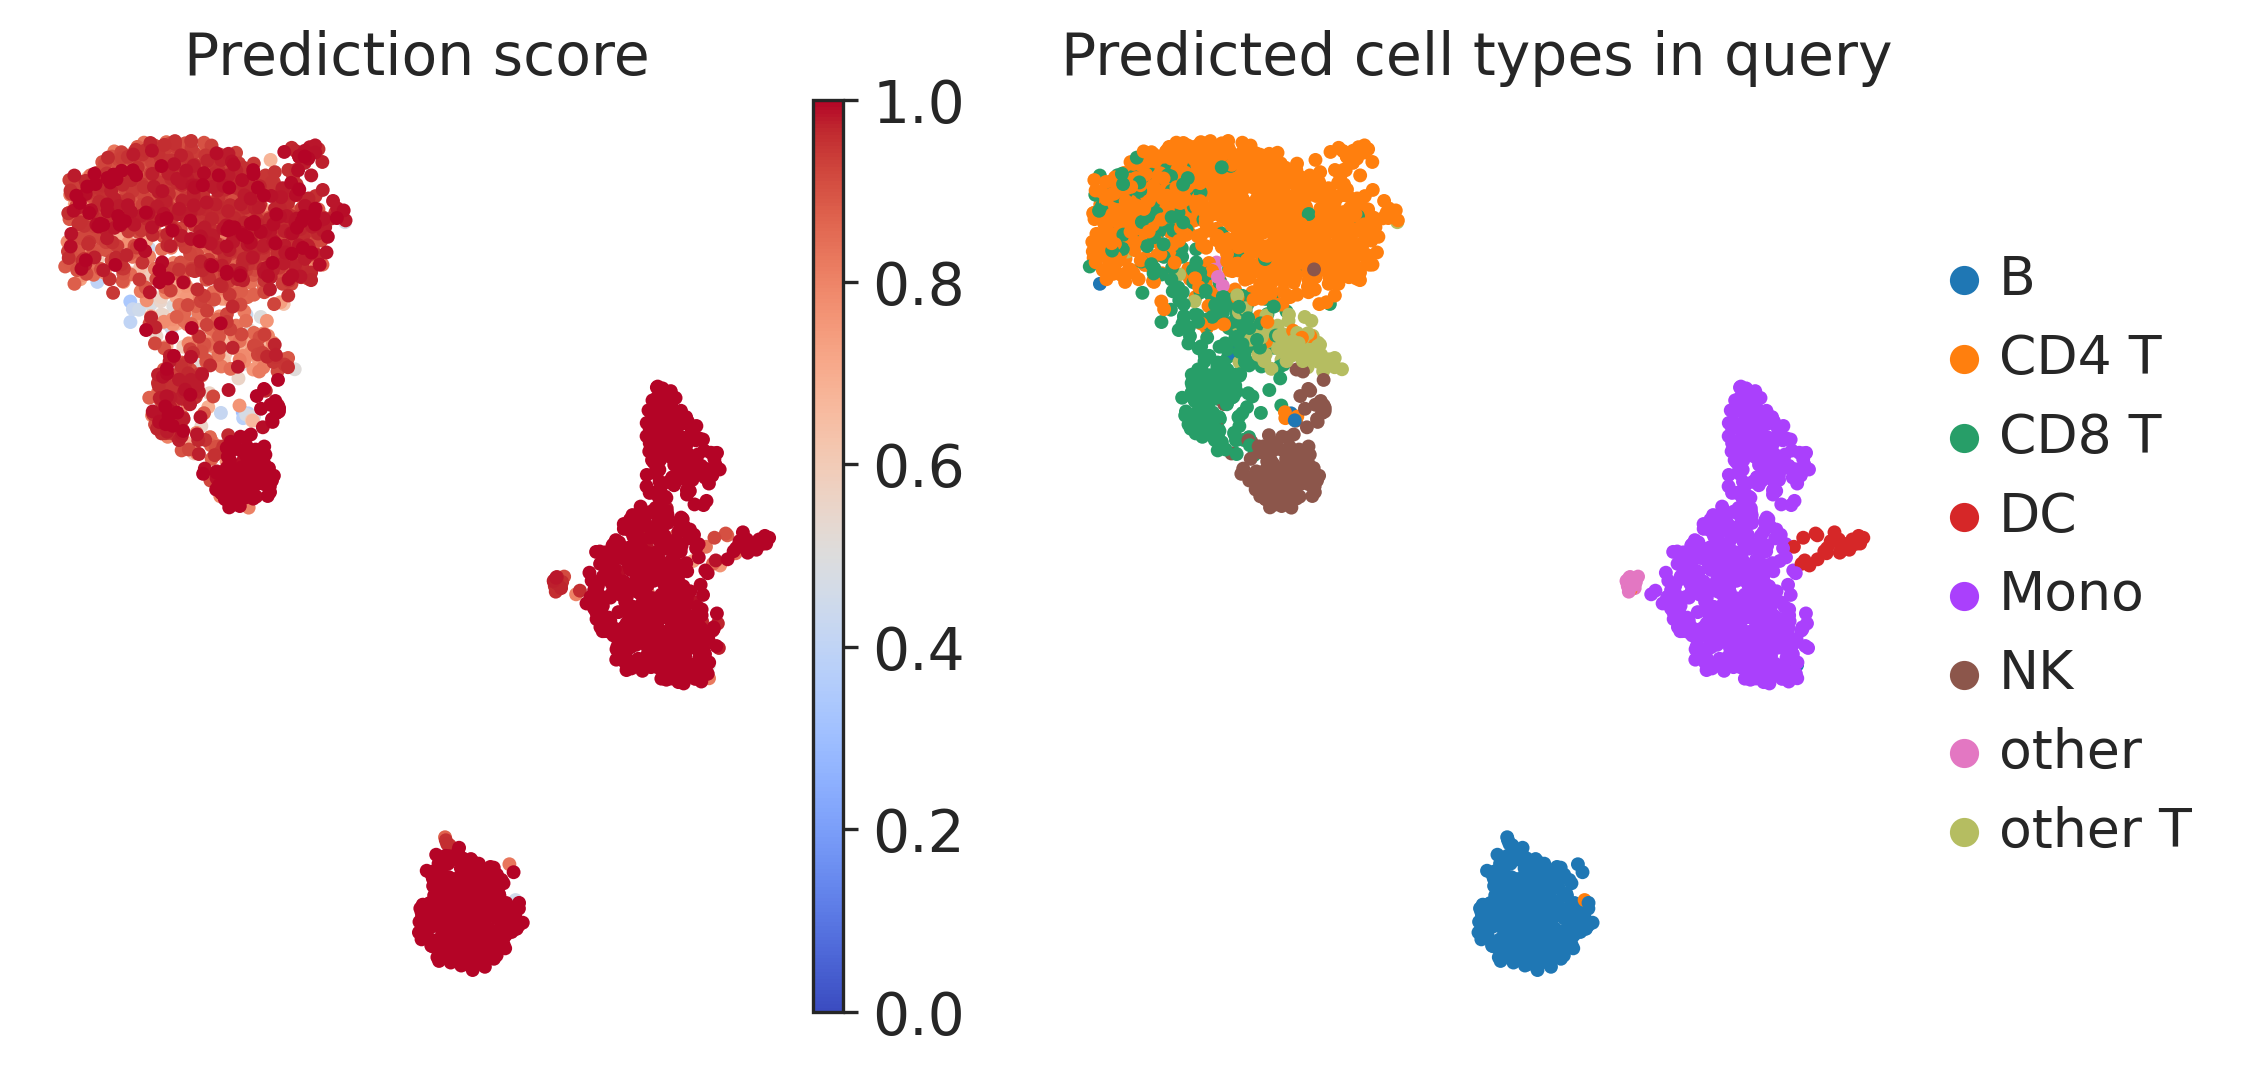

In [82]:
adata_azimuth = sc.datasets.pbmc3k()
adata_azimuth.layers["counts"] = adata_azimuth.X.copy()

sc.pp.normalize_total(adata_azimuth)
sc.pp.log1p(adata_azimuth)

sc.pp.highly_variable_genes(
    adata_azimuth,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

sc.pp.scale(adata_azimuth)
sc.tl.pca(adata_azimuth)

sc.pp.neighbors(
    adata_azimuth,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

sc.tl.umap(adata_azimuth)

adata_azimuth.obs["celltype_l1_predicted"] = pred.loc[adata_azimuth.obs_names]["predicted.celltype.l1"]
adata_azimuth.obs["l1_prediction_score"] = pred.loc[adata_azimuth.obs_names]["predicted.celltype.l1.score"]

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata_azimuth, color="celltype_l1_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata_azimuth, color="l1_prediction_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

Локальный Azimuth проклассифицировал всё так же, как и его веб-сервисный собрат. 

*Напишите функцию, которая будет на вход брать два объекта AnnData (референс и таргет), а на выходе добавлять в объект с таргетом колонку с предсказанными типами клеток.*

In [ ]:
def annotate_cells(reference,query):
  reference.layers["counts"] = reference.X.copy()
  reference.obs["ref_query"] = "reference"
  query.obs["ref_query"] = "query"
  query.obs["donor"] = "query"
  query.obs.index = [f"{bc.split('-')[0]}:query" for bc in query.obs.index]
  reference.obs.index = [f"{bc.split('_')[1]}:{bc.split('_')[0]}" for bc in reference.obs.index]
  adata_concat = query.concatenate(reference, index_unique=None)
  adata_concat.layers["counts"] = adata_concat.X.copy()
  del adata_concat.obs["batch"]
  sc.pp.normalize_total(adata_concat)
  sc.pp.log1p(adata_concat)
  sc.pp.highly_variable_genes(
      adata_concat,
      n_top_genes=3000,
      flavor="seurat_v3",
      layer="counts",
      batch_key="donor"
  )
  sc.pp.scale(adata_concat)
  sc.tl.pca(adata_concat)
  sc.external.pp.harmony_integrate(adata_concat, key="donor", max_iter_harmony=20)
  sc.pp.neighbors(
      adata_concat,
      use_rep="X_pca_harmony",
      n_pcs=30
  )
  sc.tl.umap(adata_concat)
  sc.pp.neighbors(adata_concat, use_rep="X_pca_harmony", n_pcs=30, n_neighbors=20, key_added="prediction")
  celltype_predicted = []
  prediction_score = []
  counter = 0
  for bc in adata_concat.obs_names:
    if adata_concat.obs.loc[bc]["ref_query"] == "reference":
      celltype_predicted.append(float("NaN"))
      prediction_score.append(float("NaN"))
    else:
      neighbors_celltype = adata_concat.obs["celltype.l1"][(adata_concat.obsp["prediction_distances"][counter] > 0).A[0]]
      if (~neighbors_celltype.isnull()).sum() == 0:
        celltype_predicted.append("Unknown")
        prediction_score.append(float("NaN"))
      else:
        neighbors_celltype = neighbors_celltype[~neighbors_celltype.isnull()]
        ct = neighbors_celltype.value_counts().index[0]
        score = neighbors_celltype.value_counts()[0] / len(neighbors_celltype)
        prediction_score.append(score)
        celltype_predicted.append(ct)
    counter += 1
  adata_concat.obs["celltype_predicted"] = celltype_predicted
  adata_concat.obs["prediction_score"] = prediction_score
  query.obs["celltype_predicted"] = list(adata_concat[adata.obs_names].obs["celltype_predicted"])
  query.obs["prediction_score"] = list(adata_concat[adata.obs_names].obs["prediction_score"])
  return query

In [ ]:
adata_reference = sc.read_h5ad("PBMC_Satija.h5ad")
adata = sc.datasets.pbmc3k()
adata = annotate_cells(adata_reference, adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'ref_query', 'donor', 'celltype_predicted', 'prediction_score'
    var: 'gene_ids'

*Запустите Symphony через rpy2. Сравните результаты Azimuth, Symphony и собственноручно написанного алгоритма (на всех уровнях аннотации). Как думаете, какой алгоритм работает лучше и почему? Визуализируйте результаты при помощи нескольких cofusion matrix.*

In [4]:
%%R
devtools::install_github("immunogenomics/symphony")
library("symphony")

  Use `force = TRUE` to force installation



In [4]:
%%R


In [ ]:
#Загрузим созданный 10x-PBMC референс с сайта и сохраним его, для того, чтобы потом использовать, так же поступим с UMAPом
!wget "https://zenodo.org/record/5090425/files/pbmcs_10x_reference.rds"
!wget "https://zenodo.org/record/5090425/files/pbmcs_10x_uwot_model"

#Эти файлы надо ещё поместить в специальную папку pre-built references, но я это уже вручную сделал

In [108]:
adata = sc.datasets.pbmc3k()
adata.obs["tissue"] = "PBMC"

ro.r("library(Seurat)")
ro.r("library(ggrepel)")
ro.globalenv["adata"] = adata
ro.r('adata <- as.Seurat(adata,data=NULL,counts="X")')
ro.r('adata <- RenameAssays(adata,originalexp="RNA")')
ro.r('metadata <- adata@meta.data')
ro.r('counts <- GetAssayData(object = adata, slot = "counts")')
ro.r('ref_pbmc <- readRDS("./pbmcs_10x_reference.rds")')
ro.r('query = mapQuery(exp_query = counts, metadata_query = metadata,ref_obj = ref_pbmc, do_normalize = FALSE)')
ro.r('query = knnPredict(query, ref_pbmc, train_labels = ref_pbmc$meta_data$cell_type, k = 30, confidence = TRUE)')
adata_symphony = ro.r('a <- query$meta_data')

Не могу не отметить странную особенность Symphony - если пытаться вытащить предсказания кластеров из R, то они превращаются блин в номера (то есть, не B-cells, а 5), я НЕ ПОНИМАЮ, КАК ЭТО ПРОИСХОДИТ И ПОЧЕМУ. Но вот как есть, так есть.

In [109]:
adata_symphony

orig.ident  nCount_originalexp  nFeature_originalexp tissue  \
AAACATACAACCAC-1           1              2421.0                   781   PBMC   
AAACATTGAGCTAC-1           1              4903.0                  1352   PBMC   
AAACATTGATCAGC-1           1              3149.0                  1131   PBMC   
AAACCGTGCTTCCG-1           1              2639.0                   960   PBMC   
AAACCGTGTATGCG-1           1               981.0                   522   PBMC   
...                      ...                 ...                   ...    ...   
TTTCGAACTCTCAT-1           1              3461.0                  1155   PBMC   
TTTCTACTGAGGCA-1           1              3447.0                  1227   PBMC   
TTTCTACTTCCTCG-1           1              1684.0                   622   PBMC   
TTTGCATGAGAGGC-1           1              1024.0                   454   PBMC   
TTTGCATGCCTCAC-1           1              1985.0                   724   PBMC   

                  nCount_RNA  nFeature_RNA  cell_type_pred_knn  \
AAACATACAACCAC-1      2421.0           781                   9   
AAACATTGAGCTAC-1      4903.0          1352                   1   
AAACATTGATCAGC-1      3149.0          1131                   8   
AAACCGTGCTTCCG-1      2639.0           960                   5   
AAACCGTGTATGCG-1       981.0           522                   7   
...                      ...           ...                 ...   
TTTCGAACTCTCAT-1      3461.0          1155                   5   
TTTCTACTGAGGCA-1      3447.0          1227                   1   
TTTCTACTTCCTCG-1      1684.0           622                   1   
TTTGCATGAGAGGC-1      1024.0           454                   1   
TTTGCATGCCTCAC-1      1985.0           724                   8   

                  cell_type_pred_knn_prob  
AAACATACAACCAC-1                 1.000000  
AAACATTGAGCTAC-1                 0.966667  
AAACATTGATCAGC-1                 1.000000  
AAACCGTGCTTCCG-1                 0.933333  
AAACCGTGTATGCG-1                 0.966667  
...                                   ...  
TTTCGAACTCTCAT-1                 0.766667  
TTTCTACTGAGGCA-1                 0.700000  
TTTCTACTTCCTCG-1                 1.000000  
TTTGCATGAGAGGC-1                 1.000000  
TTTGCATGCCTCAC-1                 0.800000  

[2700 rows x 8 columns]

In [110]:
numbers_to_celltypes = {1:"B cells",2:"Dendritic cells",
                        3:"HSC",
                        4:"Megakaryocytes",
                        5:"CD14+ Monocytes",
                        6:"CD16+ Monocytes",
                        7:"NK cells",
                        8:"CD4 T cells",
                        9:"CD8 T cells"}

In [111]:
adata_symphony["cell_type_pred_knn"] = [numbers_to_celltypes[i] for i in adata_symphony["cell_type_pred_knn"]]

In [ ]:
adata_symphony

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Prediction score'}, xlabel='UMAP1', ylabel='UMAP2'>

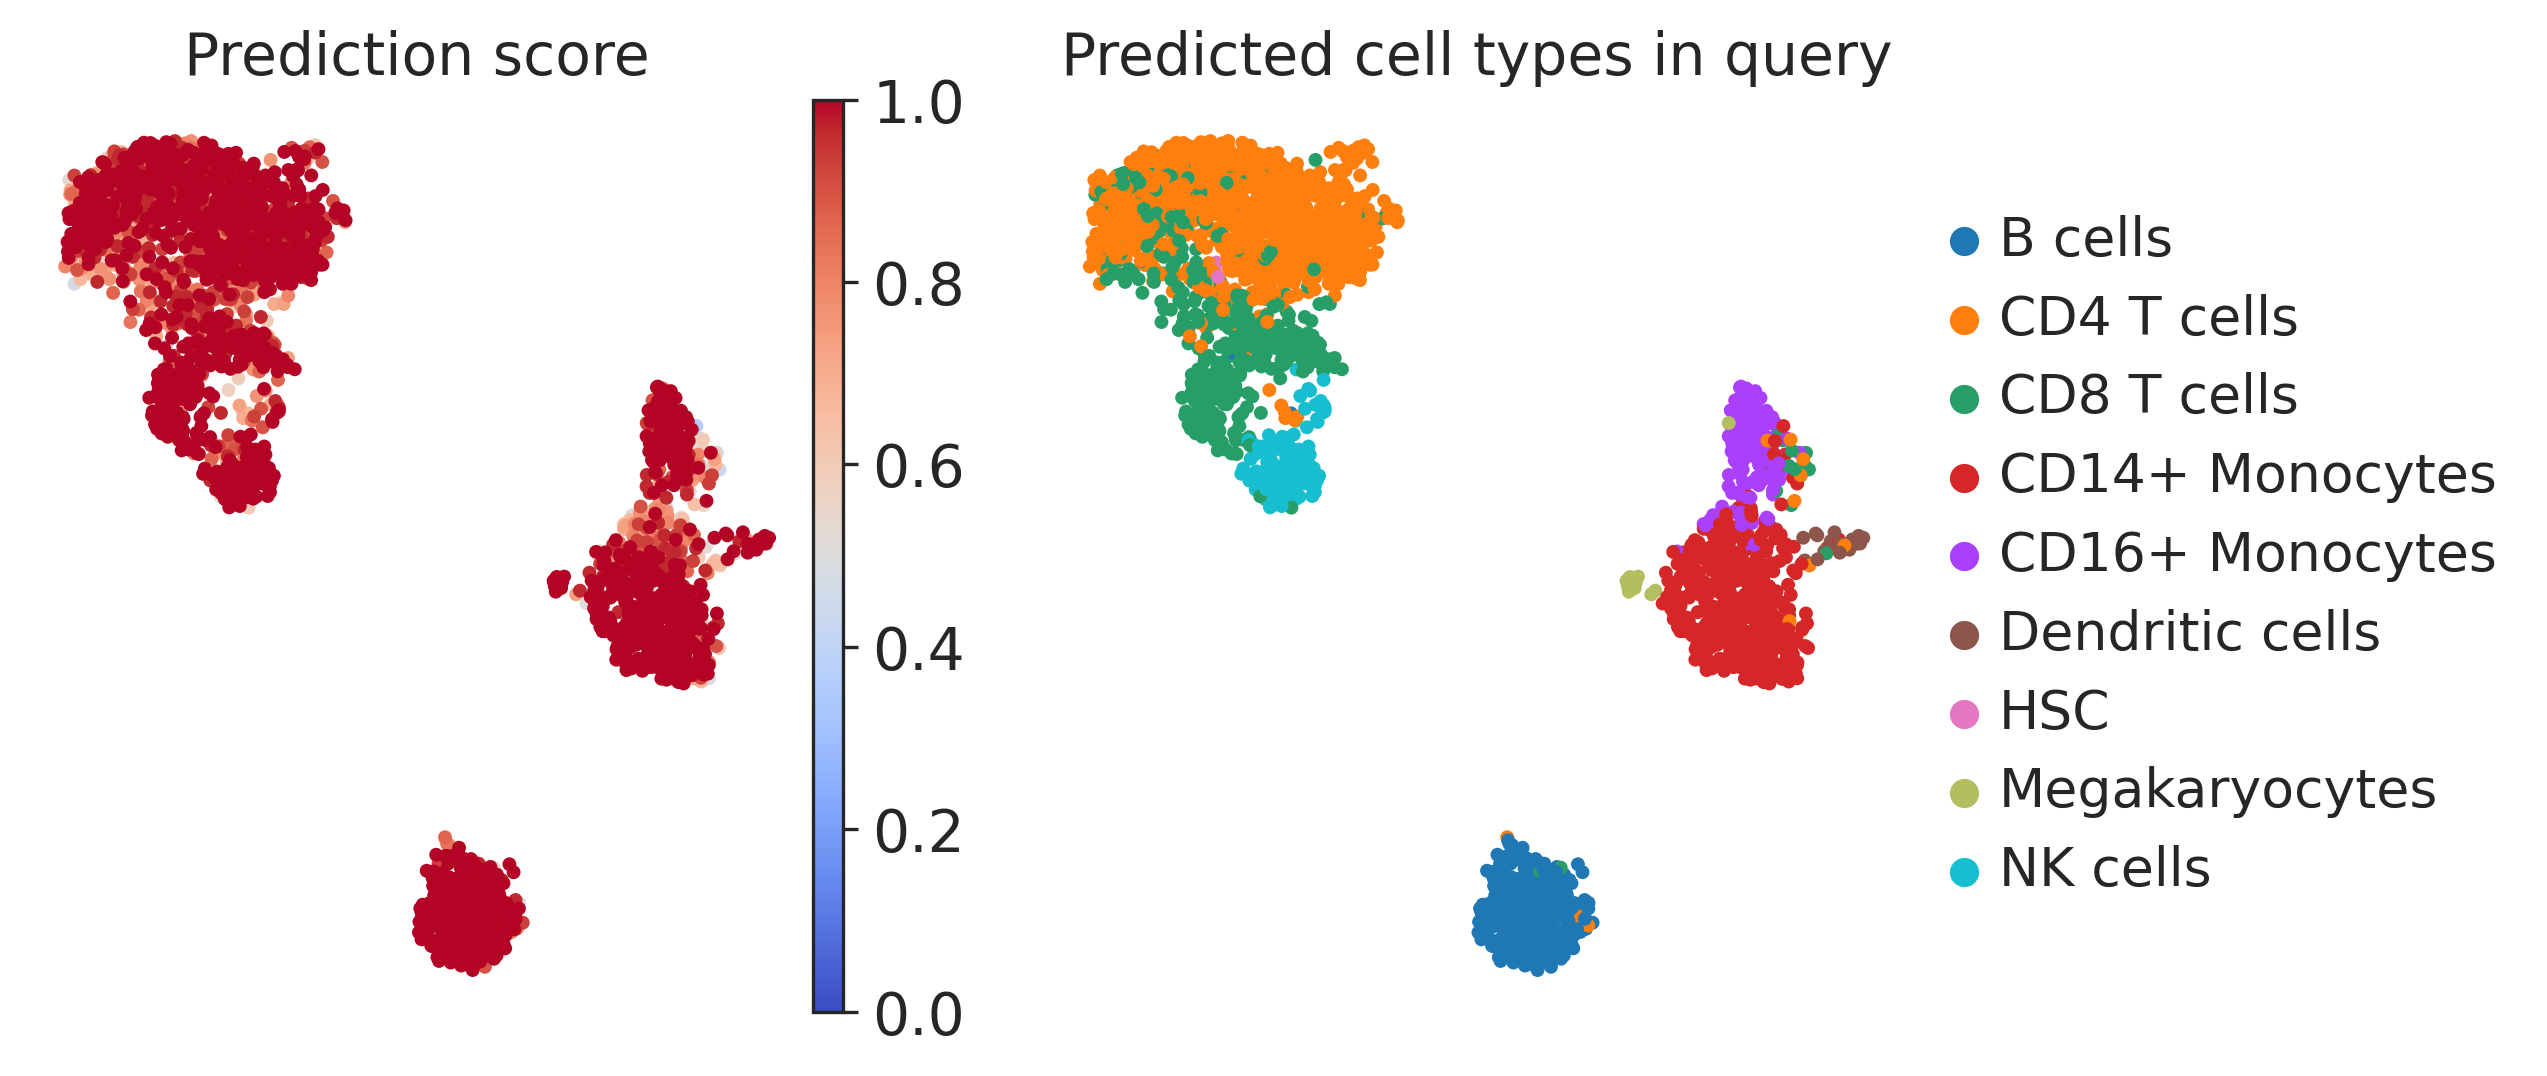

In [113]:
adata_symph = sc.datasets.pbmc3k()
adata_symph.layers["counts"] = adata_symph.X.copy()

sc.pp.normalize_total(adata_symph)
sc.pp.log1p(adata_symph)

sc.pp.highly_variable_genes(
    adata_symph,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts"
)

sc.pp.scale(adata_symph)
sc.tl.pca(adata_symph)

sc.pp.neighbors(
    adata_symph,
    n_pcs=30,
    n_neighbors=20,
    knn=True
)

sc.tl.umap(adata_symph)

adata_symph.obs["celltype_l1_predicted"] = adata_symphony.loc[adata_symph.obs_names]["cell_type_pred_knn"]
adata_symph.obs["l1_prediction_score"] = adata_symphony.loc[adata_symph.obs_names]["cell_type_pred_knn_prob"]

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, dpi=150)

sc.pl.umap(adata_symph, color="celltype_l1_predicted", frameon=False, title="Predicted cell types in query", ax=axes[1], show=False)
sc.pl.umap(adata_symph, color="l1_prediction_score", frameon=False, title="Prediction score", ax=axes[0], show=False, cmap="coolwarm", vmin=0, vmax=1)

In [ ]:
adata_true = sc.datasets.pbmc3k_processed()

In [126]:
adata_azimuth_conf = adata_azimuth[list(adata_true.obs.index)]
adata_symph_conf = adata_symph[list(adata_true.obs.index)]

In [128]:
azimuth_to_true = {"B":"B cells",
                   "CD4 T": "CD4 T cells",
                   "CD8 T": "CD8 T cells",
                   "DC": "Dendritic cells",
                   "Mono":"Monocytes",
                   "NK":"NK cells",
                   "other":"other",
                   "other T": "other T"}
adata_azimuth_conf.obs["celltype_l1_predicted"] = [azimuth_to_true[i] for i in adata_azimuth_conf.obs["celltype_l1_predicted"]]

<ipython-input-128-d549bd515375>:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_azimuth_conf.obs["celltype_l1_predicted"] = [azimuth_to_true[i] for i in adata_azimuth_conf.obs["celltype_l1_predicted"]]


In [130]:
from sklearn import metrics 
symph = metrics.confusion_matrix(adata_true.obs["louvain"], adata_symph_conf.obs["celltype_l1_predicted"])
azi = metrics.confusion_matrix(adata_true.obs["louvain"], adata_azimuth_conf.obs["celltype_l1_predicted"])

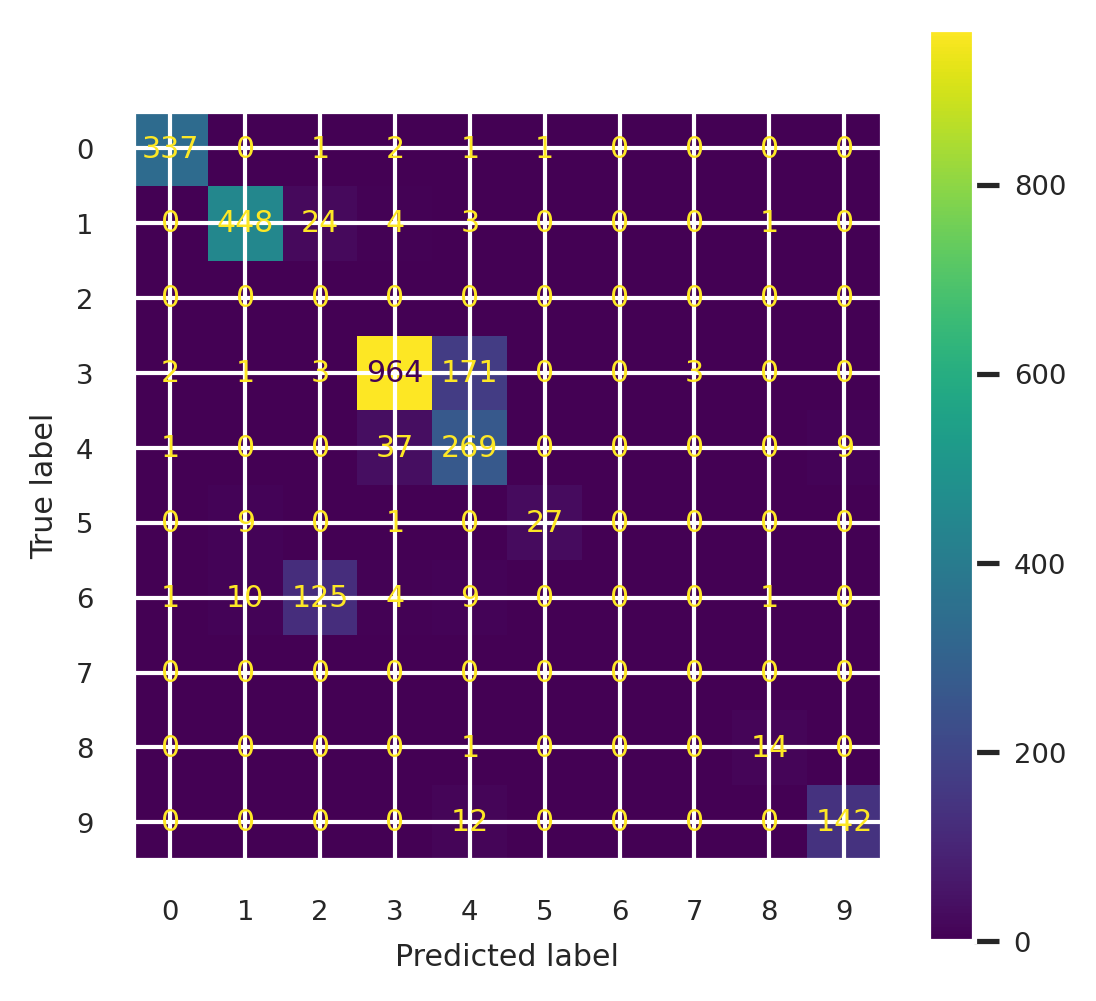

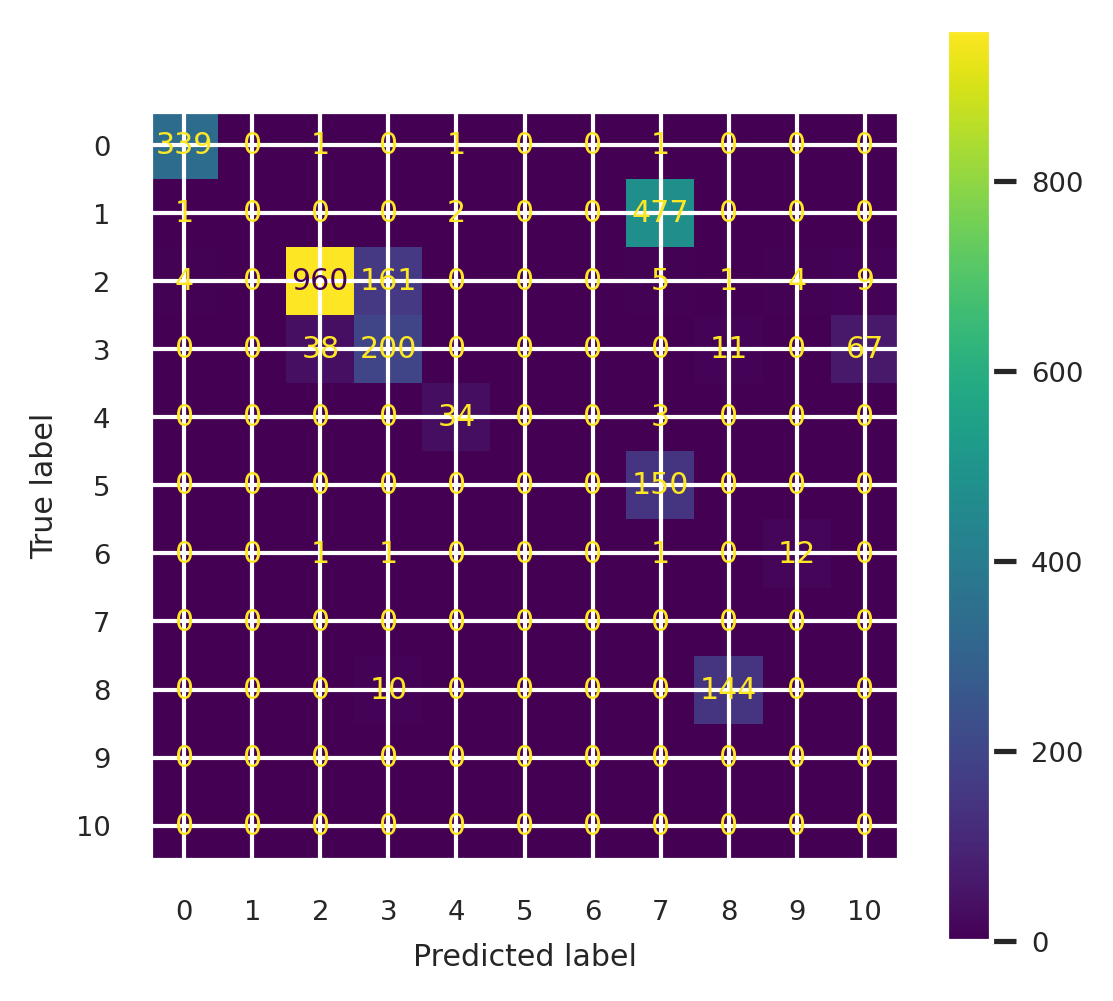

In [137]:
sns.set(font_scale=0.6)
disp_symph = metrics.ConfusionMatrixDisplay(confusion_matrix=symph)
disp_azi = metrics.ConfusionMatrixDisplay(confusion_matrix=azi)
disp_symph.plot()
disp_azi.plot()

Как я понял, Symphony - это буквально точь-в-точь алгоритм, который мы на семинаре реализовывали, поэтому я его в рассмотрение не включил.

Вообще, кажется, что лучше сработал Symphony, однако тут спорно, потому что в каждом дурацком алгоритме своя классификация клеток (где-то Monocytes, а где-то CD14+_Monocytes и CD16+_Monocytes, на этой матрице это будет выглядеть как ошибка классификатора).